<a href="https://colab.research.google.com/github/mariajosecaicedo/Tasa-de-Ocupados-seg-n-datos-del-DANE/blob/main/Ocupados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --no-cache-dir pmdarima==2.0.3 statsmodels==0.14.0

!pip install numpy==1.23.5 pandas==2.2.2 scikit-learn==1.6.1 pmdarima==2.0.3 statsmodels==0.14.0

In [2]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from tabulate import tabulate
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pmdarima.arima import auto_arima
from pmdarima.utils import acf,pacf
from pmdarima.arima import ARIMA
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.sandbox.stats.runs import runstest_1samp
from tabulate import tabulate



# **Taller 1**
Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

En este documento estudiaremos la serie de tiempo de ocupados, con el fin de pronosticar los 6 meses posteriores a los datos que se tienes del número de **ocupados** con el fin de realizar un pronóstico de corto plazo. Se utilizaron modelos de suavizamiento exponencial sobre 216 observaciones históricas, reservando los últimos ese lapso para el testeo.

A continuacion cargaremos todas las librerias

## **2. Carga de datos**

Nuestra primera tarea será leer el archivo de Excel. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se procede a cargar los datos

In [4]:
data = pd.read_excel("/content/drive/MyDrive/Fundamentos de analitica/analitica 2/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

#imprimir los 6 ultimos
data.tail(6)

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2019-01-01,13.739328,10314.438,1642.851,6343.066
2019-02-01,12.427409,10557.917,1498.272,6264.403
2019-03-01,11.975098,10760.776,1463.919,6116.140
2019-04-01,11.144286,10632.028,1333.469,6395.575
2019-05-01,11.500000,10813.000,1369.000,6199.000
2019-06-01,10.700000,10848.000,1306.000,6247.000


(222, 4)


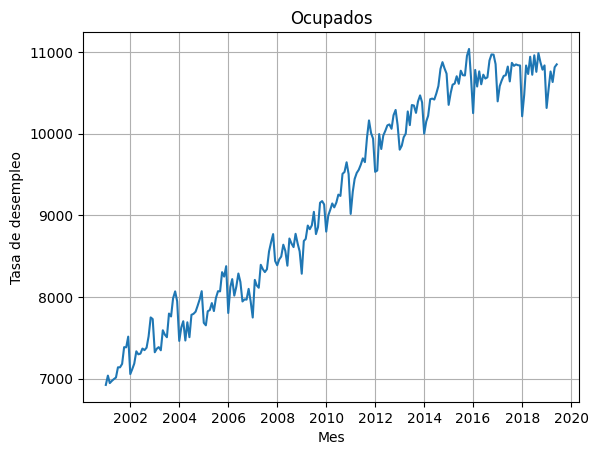

In [5]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
plt.title("Ocupados")
plt.xlabel("Mes")
plt.ylabel("Tasa de desempleo")
plt.plot(data[["Ocupados"]])
plt.grid()

# 🔽 Guardar imagen en archivo PNG
plt.savefig("Ocupados.png", dpi=300, bbox_inches="tight")
plt.show()


## **3. Encontrando los componentes de una serie de tiempo**

Encontrando los componentes de una serie de **Tiempo** desagregada.

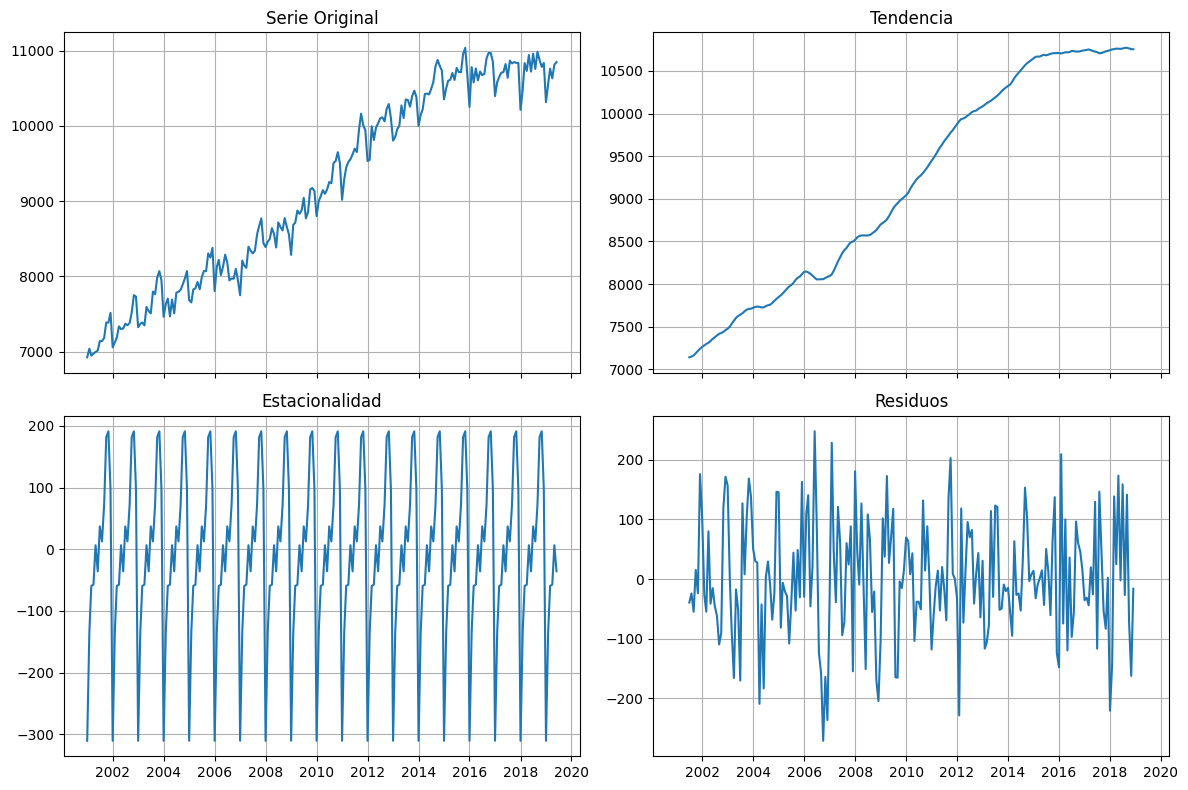

In [6]:
resultado = seasonal_decompose(data['Ocupados'], model='additive')

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# Serie original
axes[0, 0].plot(data.index, data['Ocupados'])
axes[0, 0].set_title('Serie Original')
axes[0, 0].grid()

# Tendencia
axes[0, 1].plot(data.index, resultado.trend)
axes[0, 1].set_title('Tendencia')
axes[0, 1].grid()

# Estacionalidad
axes[1, 0].plot(data.index, resultado.seasonal)
axes[1, 0].set_title('Estacionalidad')
axes[1, 0].grid()

# Residuos
axes[1, 1].plot(data.index, resultado.resid)
axes[1, 1].set_title('Residuos')
axes[1, 1].grid()


plt.tight_layout()

# 🔽 Guardar imagen en archivo PNG
plt.savefig("componentes_serie_tiempo.png", dpi=300)

plt.show()


In [7]:
Ocupados_componentes = seasonal_decompose(data[["Ocupados"]],model="additive")
Ocupados_componentes.seasonal

,seasonal
mes,
2001-01-01,-310.570069
2001-02-01,-134.331549
2001-03-01,-59.585841
2001-04-01,-57.385905
2001-05-01,6.435912
...,...
2019-02-01,-134.331549
2019-03-01,-59.585841
2019-04-01,-57.385905


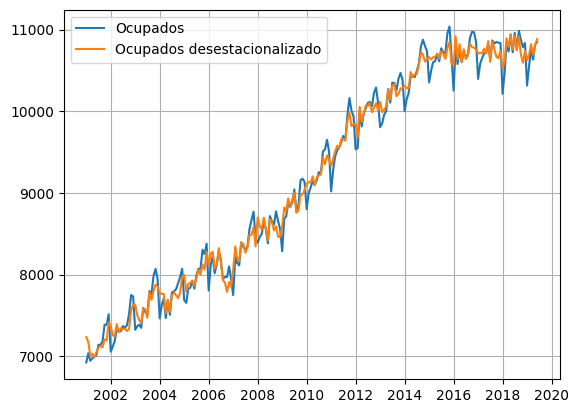

In [8]:
Ocupados_desestacionalizada = data["Ocupados"]-Ocupados_componentes.seasonal

plt.plot(data[["Ocupados"]],label="Ocupados")
plt.plot(Ocupados_desestacionalizada,label="Ocupados desestacionalizado")
plt.legend()
plt.grid()
plt.show()


Podemos observar que sin estacionalidad la tendencia de los datos es muy cerca a los datos reales.

## **4. Pronosticando metodos de suavización**

Antes de continuar es importante guardar una parte de la muestra para evaluar el comportamiento de los modelos por fuera de muestra (out-of-sample). Guardemos un año de datos.

In [9]:
data.shape #Tamaño de dataset

(222, 4)

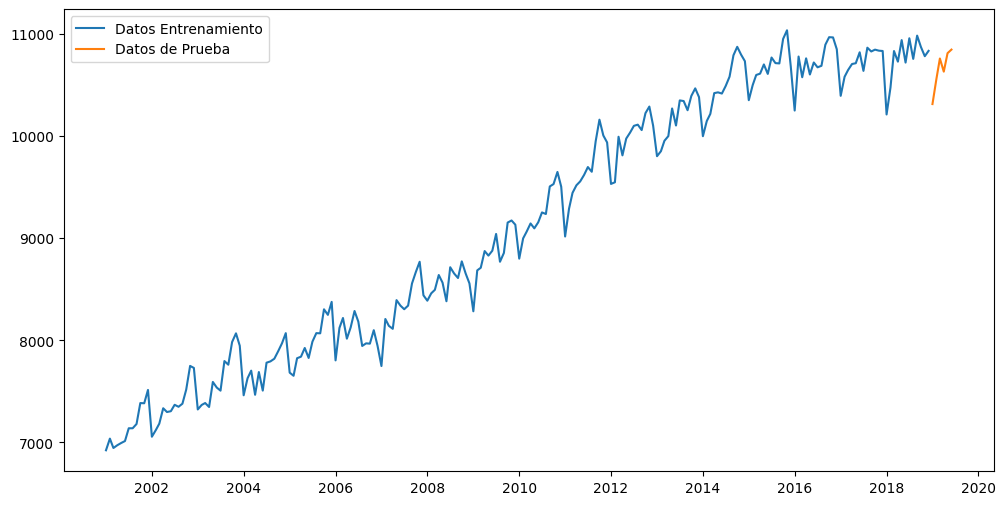

In [10]:
train_len = 216 #Tamaño menos los periodos que se quiere evaluar
train_Ocupados = data[["Ocupados"]][:train_len]
test_Ocupados = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ocupados,label="Datos Entrenamiento")
plt.plot(test_Ocupados,label="Datos de Prueba")
plt.legend()
plt.show()

Rervisamos las particiones de entrenamiento y prueba.

In [11]:
train_Ocupados

,Ocupados
mes,
2001-01-01,6923.604
2001-02-01,7037.746
2001-03-01,6945.973
2001-04-01,6973.079
2001-05-01,6994.462
...,...
2018-08-01,10756.782
2018-09-01,10984.928
2018-10-01,10874.338


In [12]:
test_Ocupados

,Ocupados
mes,
2019-01-01,10314.438
2019-02-01,10557.917
2019-03-01,10760.776
2019-04-01,10632.028
2019-05-01,10813.000
2019-06-01,10848.000


### **4.1 Promedio movil**

In [13]:
## Considerando el dato actual de 2 a 5 ventanas
ma_2= train_Ocupados.rolling(2,min_periods=2).mean()
ma_3= train_Ocupados.rolling(3,min_periods=2).mean()
ma_4= train_Ocupados.rolling(4,min_periods=2).mean()
ma_5= train_Ocupados.rolling(5,min_periods=2).mean()

In [14]:
## Sin considerar el dato actual  de 2 a 5 ventanas
ma_2= train_Ocupados.shift().rolling(2,min_periods=2).mean()
ma_3= train_Ocupados.shift().rolling(3,min_periods=2).mean()
ma_4= train_Ocupados.shift().rolling(4,min_periods=2).mean()
ma_5= train_Ocupados.shift().rolling(5,min_periods=2).mean()

In [15]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [16]:
ma_2_f= fore_ma(train_Ocupados,2,6)
ma_3_f= fore_ma(train_Ocupados,3,6)
ma_4_f= fore_ma(train_Ocupados,4,6)
ma_5_f= fore_ma(train_Ocupados,5,6)

In [17]:
#hacer el rmse_ma_
rmse_ma_2= np.sqrt(mean_squared_error(test_Ocupados[:6],ma_2_f ))
rmse_ma_3= np.sqrt(mean_squared_error(test_Ocupados[:6],ma_3_f ))
rmse_ma_4= np.sqrt(mean_squared_error(test_Ocupados[:6],ma_4_f ))
rmse_ma_5= np.sqrt(mean_squared_error(test_Ocupados[:6],ma_5_f ))

In [18]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5)

242.8347290019203 250.36984465630144 270.6203851653251 266.5247179311155


El mejor RMSE es el de dos ventanas, presentando el error mas pequeño que se aproxima a 243 personas ocupadas.

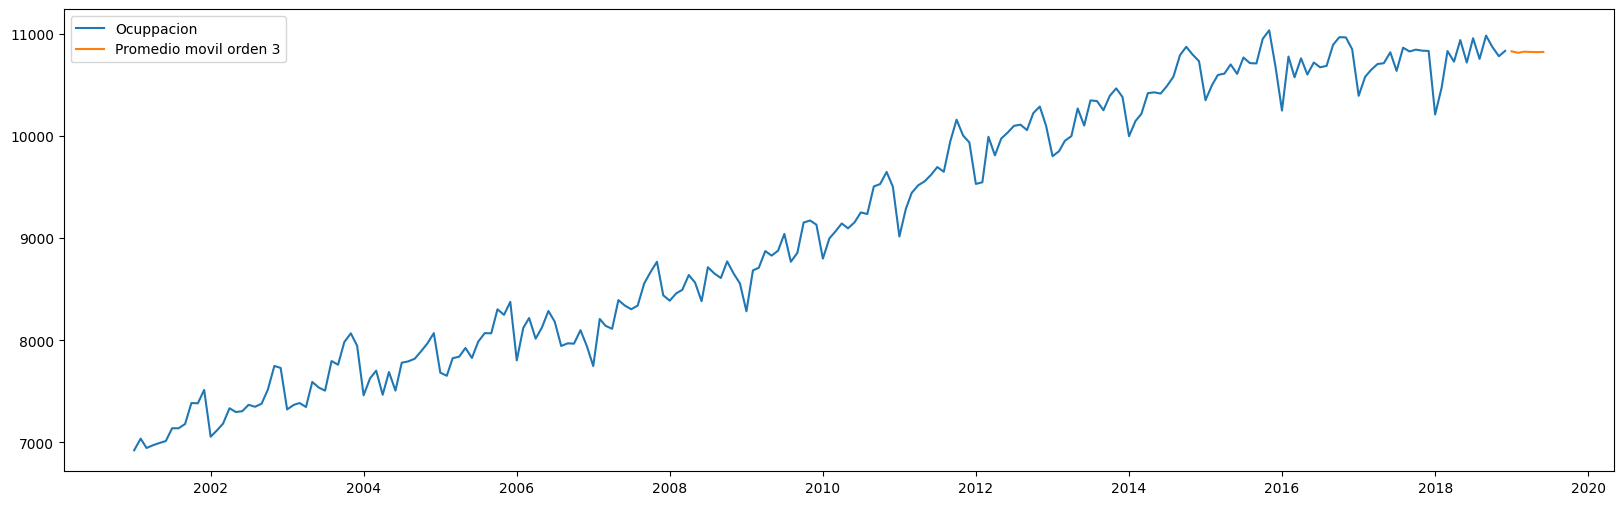

In [19]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_Ocupados,label="Ocuppacion")
plt.plot(ma_3_f,label="Promedio movil orden 3")
plt.legend()
plt.show()

### **4.2 Suavizacion Exponencial Simple**

In [20]:
# Build model.
ets_model = ETSModel(endog=train_Ocupados["Ocupados"],error="add")#,trend="add",seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

            Point_forecast      lower_95      upper_95
2019-01-01    10830.738569  10476.461345  11185.015792
2019-02-01    10830.738569  10411.310139  11250.166999
2019-03-01    10830.738569  10354.999076  11306.478061
2019-04-01    10830.738569  10304.681612  11356.795526
2019-05-01    10830.738569  10258.773728  11402.703409
2019-06-01    10830.738569  10216.286263  11445.190874


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


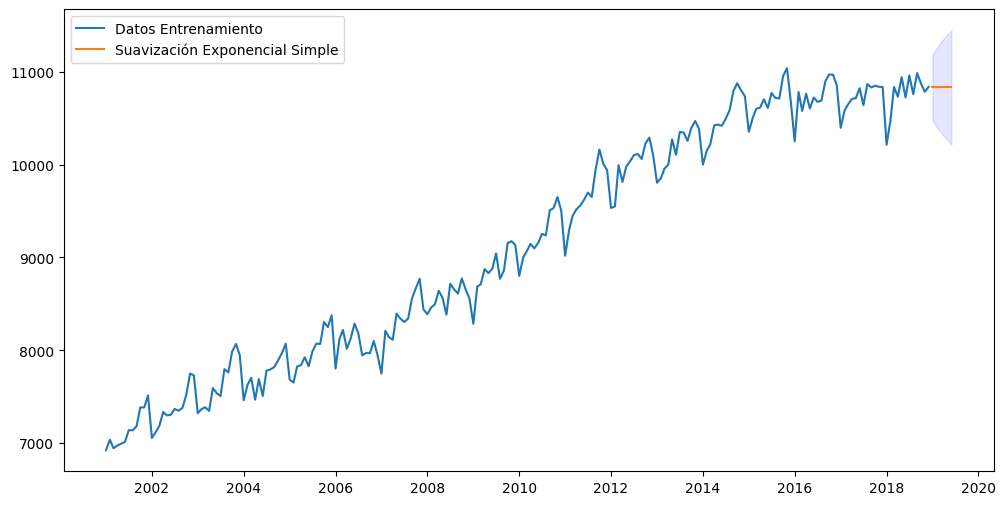

In [21]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ocupados,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

En esta caso el α estimado es 0.6337323614899885.Y el RMSE en la muestra de evaluación es 253.6.

In [22]:
ets_result.alpha

0.6337323614899885

In [23]:
rmse = np.sqrt(mean_squared_error(test_Ocupados[:6],point_forecast ))
print(rmse)

253.63725759469287


La suavizacion exponencial simple, hace un trabajo un poco inferior al promedio movil. aumentado el RMSE a 253, casi 254 personas.

### **4.3 Suavizacion Exponencial Lineal (Holt)**

In [24]:
# Build model.
ets_model = ETSModel(endog=train_Ocupados["Ocupados"],error="add",trend="add")#,seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

            Point_forecast      lower_95      upper_95
2019-01-01    10862.758893  10510.444660  11215.073126
2019-02-01    10879.826701  10472.720445  11286.932958
2019-03-01    10896.894510  10440.526909  11353.262110
2019-04-01    10913.962318  10412.222196  11415.702440
2019-05-01    10931.030127  10386.823383  11475.236870
2019-06-01    10948.097935  10363.687927  11532.507943


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


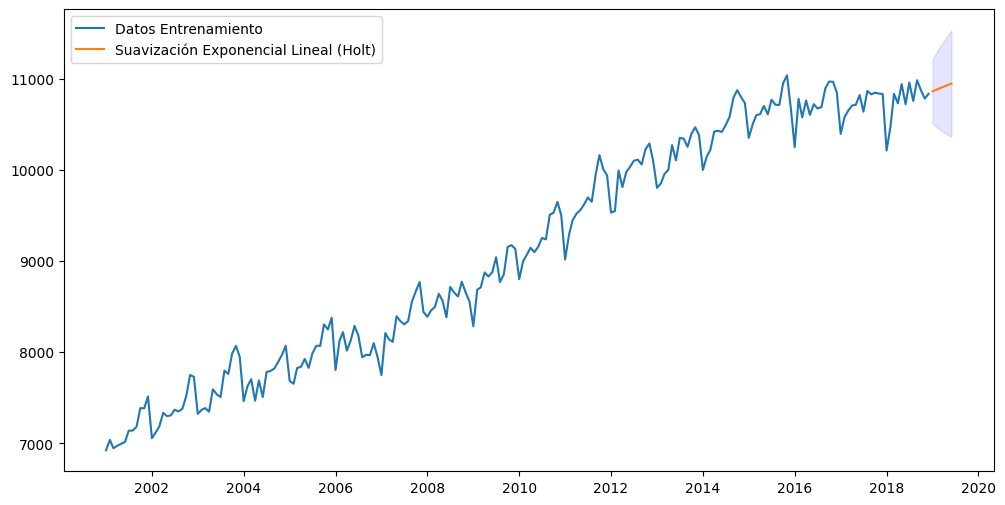

In [25]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ocupados,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

Alfa 0.5725831823098677 Beta 0.006404915956342309 RMSE 296.15, es decir aproximadamente 296 personas ocupadas o con empleo.

In [26]:
print(ets_result.alpha,ets_result.beta)

0.5725831823098677 0.006404915956342309


In [27]:
rmse_holt = np.sqrt(mean_squared_error(test_Ocupados[:6],preds_holt['Point_forecast']))
print(rmse_holt)

296.15524441244435


Este modelo empeora respercto al promedio movil con dos ventas, lo cual hace que no sea la mejor opcion hasta el momento.

## **4.3 Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

In [28]:
# Build model
ets_model = ETSModel(endog=train_Ocupados["Ocupados"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.01)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2019-01-01    10349.094194  10009.388553  10688.799835
2019-02-01    10624.690071  10264.410816  10984.969326
2019-03-01    10770.101783  10390.358132  11149.845434
2019-04-01    10786.274106  10388.012608  11184.535603
2019-05-01    10870.829275  10454.870046  11286.788504
2019-06-01    10828.784921  10395.847487  11261.722355


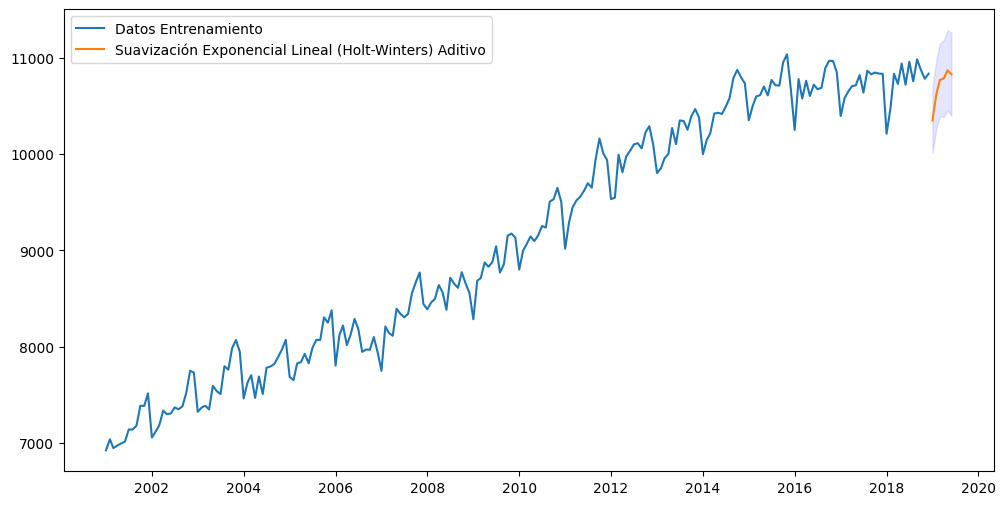

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_Ocupados, label="Datos Entrenamiento")
ax.plot(preds_hw_add['Point_forecast'], label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
ax.fill_between(preds_hw_add.index, preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
ax.legend()

# 🔽 Guardar imagen antes de mostrarla
plt.savefig("Aditivo_entreno.png", dpi=300, bbox_inches="tight")

# 🔽 Mostrar la gráfica
plt.show()

In [30]:
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.35322663405671384 3.5322663405671385e-05 0.29694595046559796


In [31]:
rmse_hw_add = np.sqrt(mean_squared_error(test_Ocupados[:6],preds_hw_add['Point_forecast']))
print(rmse_hw_add)

74.44457717563775


La Suavizacion Exponencial Lineal de Holt-Winters Aditiva hace el mejor trabajo, teniendo encuenta una tendencia aditiva y una estacionalidad aditiva.El RMSE mejora a 74,4 personas ocupada.

In [32]:
# Build model.
ets_model = ETSModel(endog=train_Ocupados["Ocupados"],error="add",trend=None,seasonal="mul" , )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean

preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

            Point_forecast      lower_95      upper_95
2019-01-01    10325.781740  10110.227472  10566.059170
2019-02-01    10527.749200  10254.307340  10786.772642
2019-03-01    10611.310498  10310.272432  10912.407047
2019-04-01    10620.935091  10281.817391  10951.914542
2019-05-01    10689.617917  10307.101938  11042.815535
2019-06-01    10645.660972  10276.022768  11042.988859


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


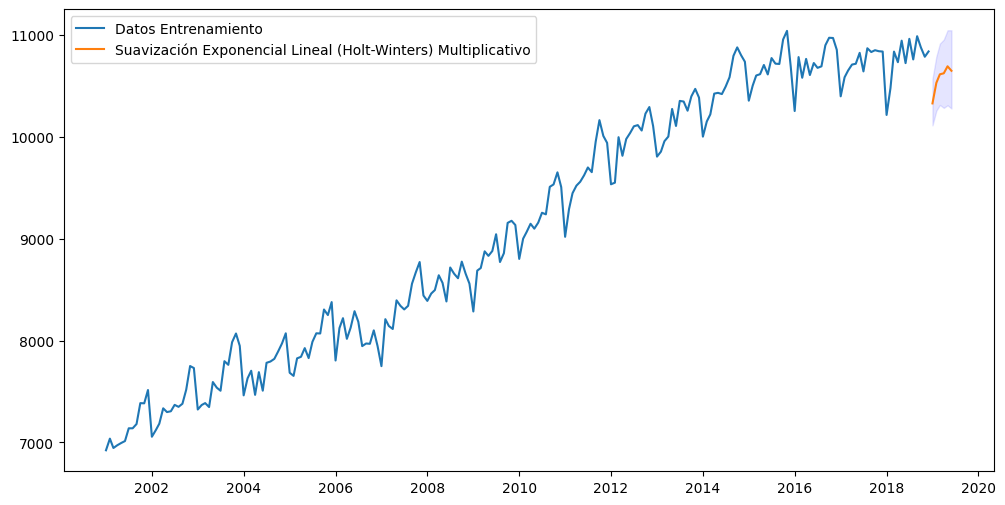

In [33]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ocupados,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [34]:
print(ets_result.alpha,ets_result.gamma)

0.5975179083987354 4.024820916012646e-05


In [35]:
rmse_hw_mul = np.sqrt(mean_squared_error(test_Ocupados[:6],preds_hw_mul['Point_forecast']))
print(rmse_hw_mul)

115.22874802708579


La Suavizacion Exponencial Lineal de Holt-Winters multiplicartiva, lo hace mejor el el promedio movil, pero no supera a Holt-Winters aditiva.

Resultados obtenidos en los RMSE **(comparativa)**.

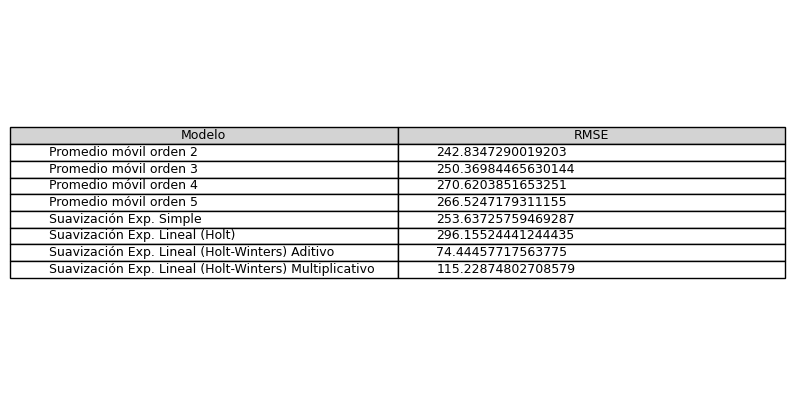

In [36]:
RMSE = {
    "Modelo": [
        "Promedio móvil orden 2",
        "Promedio móvil orden 3",
        "Promedio móvil orden 4",
        "Promedio móvil orden 5",
        "Suavización Exp. Simple",
        "Suavización Exp. Lineal (Holt)",
        "Suavización Exp. Lineal (Holt-Winters) Aditivo",
        "Suavización Exp. Lineal (Holt-Winters) Multiplicativo"
    ],
    "RMSE": [
        rmse_ma_2, rmse_ma_3, rmse_ma_4, rmse_ma_5,
        rmse, rmse_holt, rmse_hw_add, rmse_hw_mul
    ]
}

# Crear el DataFrame
df = pd.DataFrame(RMSE)

# Configurar la figura
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis("tight")
ax.axis("off")

# Dibujar la tabla con formato
tabla = ax.table(cellText=df.values, colLabels=df.columns, cellLoc="left", loc="center",
                 colColours=["lightgray"] * df.shape[1])

# Estilizar bordes y texto
tabla.auto_set_font_size(False)
tabla.set_fontsize(9)

# Guardar como imagen
plt.savefig("Resultados_tabla.png", dpi=300, bbox_inches="tight")

# Mostrar antes de guardar
plt.show()

# **Taller 2**

In [37]:
ets_model = ETSModel(endog=train_Ocupados["Ocupados"],error="add",trend="add",seasonal="add")
ets_result = ets_model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Parametros para usar en el modelo que pronosticará los siguintes 6 meses.

In [38]:
## Se obtienen los hiperparametros

print(ets_result.alpha)
print(ets_result.beta)
print(ets_result.gamma)
print(ets_result.param_names)

0.35322663405671384
3.5322663405671385e-05
0.29694595046559796
['smoothing_level', 'smoothing_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend', 'initial_seasonal.0', 'initial_seasonal.1', 'initial_seasonal.2', 'initial_seasonal.3', 'initial_seasonal.4', 'initial_seasonal.5', 'initial_seasonal.6', 'initial_seasonal.7', 'initial_seasonal.8', 'initial_seasonal.9', 'initial_seasonal.10', 'initial_seasonal.11']


In [39]:
final_model = ETSModel(endog=data["Ocupados"],error="add",trend="add",seasonal="add")
final_model_fit = final_model.fit_constrained({'smoothing_level': 0.35322663405671384,'smoothing_trend':3.5322663405671385e-05,'smoothing_seasonal':0.29694595046559796})

point_forecast=final_model_fit.forecast(6)

ci = final_model_fit.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']

print(preds_hw_mul)
print(final_model_fit.alpha)
print(final_model_fit.beta)
print(final_model_fit.gamma)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2019-07-01    10878.308947  10635.465854  11121.152041
2019-08-01    10872.265968  10614.715553  11129.816383
2019-09-01    11000.160045  10728.695248  11271.624843
2019-10-01    11032.585956  10747.883431  11317.288482
2019-11-01    11036.270784  10738.916799  11333.624769
2019-12-01    11000.264396  10690.773316  11309.755477
0.35322663405671384
3.5322663405671385e-05
0.29694595046559796


DFiferencia entre los intervalos de confianza.

In [40]:
preds_hw_mul['Diferencia_95'] = preds_hw_mul['upper_95'] - preds_hw_mul['lower_95']
print(preds_hw_mul[[ 'Diferencia_95']])

            Diferencia_95
2019-07-01     485.686187
2019-08-01     515.100830
2019-09-01     542.929595
2019-10-01     569.405052
2019-11-01     594.707970
2019-12-01     618.982160


**Pronóstico de los siguientes 6 meses**

In [41]:
print(point_forecast)

2019-07-01    10878.308947
2019-08-01    10872.265968
2019-09-01    11000.160045
2019-10-01    11032.585956
2019-11-01    11036.270784
2019-12-01    11000.264396
Freq: MS, Name: simulation, dtype: float64


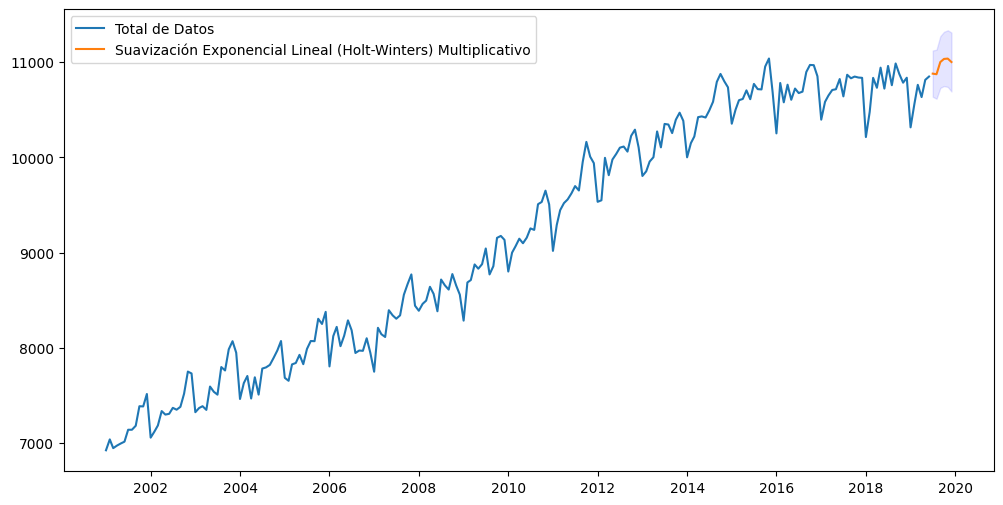

In [42]:
fig = plt.figure(figsize=(12, 6))
plt.plot(data["Ocupados"],label="Total de Datos")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()

# 🔽 Guardar imagen en archivo PNG
plt.savefig("Pronósticos.png", dpi=300, bbox_inches="tight")
plt.show()

## **EJERCICIO**
##**Proyecciones**

(222, 4)


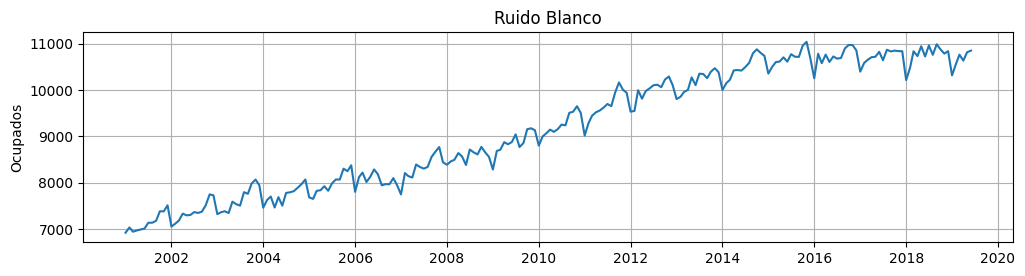

In [43]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
fig = plt.figure(figsize=(12, 6))

plt.subplot(2,1, 1)
plt.title("Ruido Blanco")
plt.ylabel("Ocupados")
plt.plot(data[["Ocupados"]])
plt.grid()

plt.show()

### **Tendencia lineal**

In [44]:
y = data["Ocupados"]
x = np.linspace(1,data.shape[0],data.shape[0])
X = sm.add_constant(x)
lin = sm.OLS(y,X)
lin_t = lin.fit()
print(lin_t.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     4729.
Date:                Thu, 19 Jun 2025   Prob (F-statistic):          1.02e-150
Time:                        22:42:32   Log-Likelihood:                -1559.9
No. Observations:                 222   AIC:                             3124.
Df Residuals:                     220   BIC:                             3131.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6962.4958     36.871    188.835      0.0

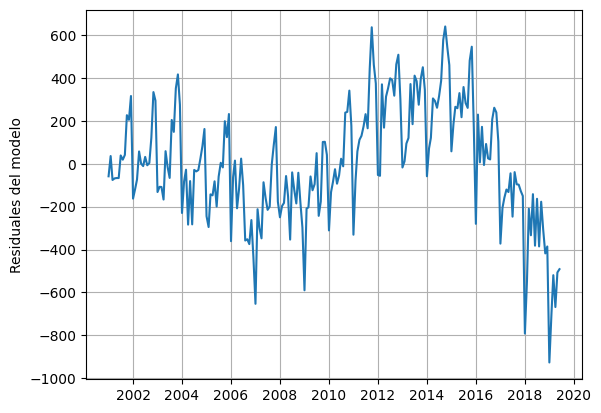

In [45]:
plt.ylabel("Residuales del modelo")
plt.plot(lin_t.resid)
plt.grid()

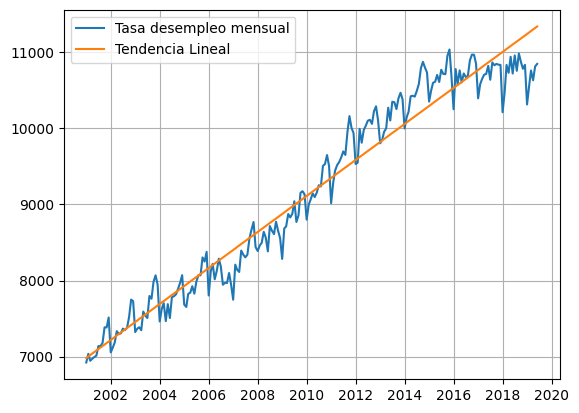

In [46]:
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(lin_t.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [47]:
h=6
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
X_for= sm.add_constant(x_for)


In [48]:
dt = lin_t.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

   Point_forecast      lower_95      upper_95
0    11359.208189  10814.820716  11903.595662
1    11378.924388  10834.471236  11923.377539
2    11398.640587  10854.121178  11943.159995
3    11418.356786  10873.770542  11962.943029
4    11438.072984  10893.419328  11982.726641
5    11457.789183  10913.067536  12002.510831


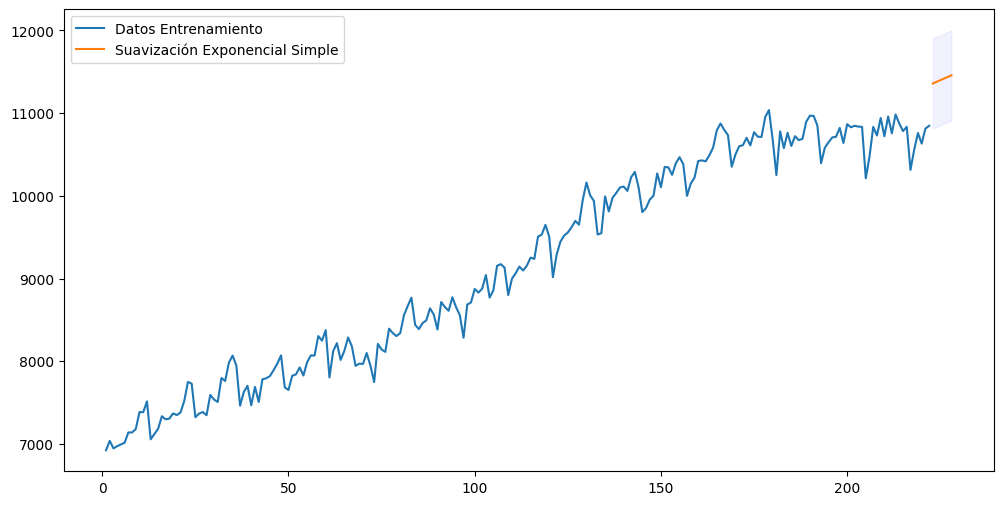

In [49]:
fig = plt.figure(figsize=(12, 6))
plt.plot(x,y,label="Datos Entrenamiento")
plt.plot(x_for,preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(x_for ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.05)
plt.legend()
plt.show()


In [50]:
rmse_lin = np.sqrt(mean_squared_error(test_Ocupados[:6], preds['Point_forecast']))
print(f"RMSE para el modelo de tendencia lineal: {rmse_lin}")

RMSE para el modelo de tendencia lineal: 769.5606053642579


### **Tendencia Cuadratica**

In [51]:
y = data["Ocupados"]
data["x"] = np.linspace(1,data.shape[0],data.shape[0])
data["x2"] = x**2
X = sm.add_constant(data[["x","x2"]])
pol = sm.OLS(y,X)
pol_2 = pol.fit()
print(pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     2560.
Date:                Thu, 19 Jun 2025   Prob (F-statistic):          1.33e-152
Time:                        22:42:33   Log-Likelihood:                -1551.0
No. Observations:                 222   AIC:                             3108.
Df Residuals:                     219   BIC:                             3118.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6790.8804     53.552    126.810      0.0

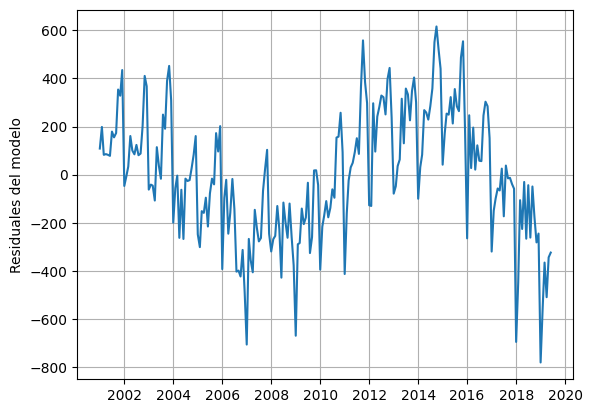

In [52]:
plt.ylabel("Residuales del modelo")
plt.plot(pol_2.resid)
plt.grid()

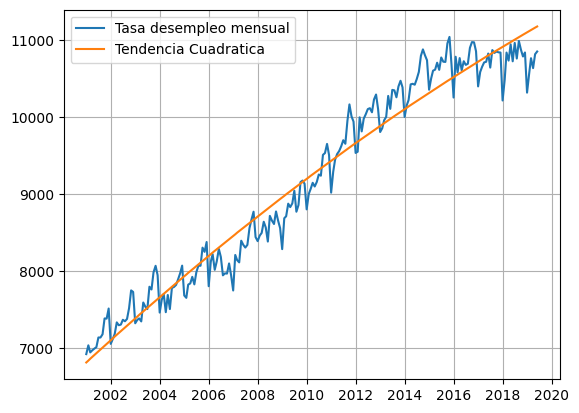

In [53]:
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(pol_2.fittedvalues,label="Tendencia Cuadratica")
plt.legend()
plt.grid()
plt.show()

In [54]:
h=6
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
X_for= sm.add_constant(np.stack((x_for, x_for**2), axis=1))

In [55]:
dt = pol_2.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

   Point_forecast      lower_95      upper_95
0    11187.592748  10657.511767  11717.673730
1    11202.691491  10672.226911  11733.156072
2    11217.749007  10686.889054  11748.608961
3    11232.765296  10701.497992  11764.032599
4    11247.740357  10716.053522  11779.427192
5    11262.674191  10730.555438  11794.792944


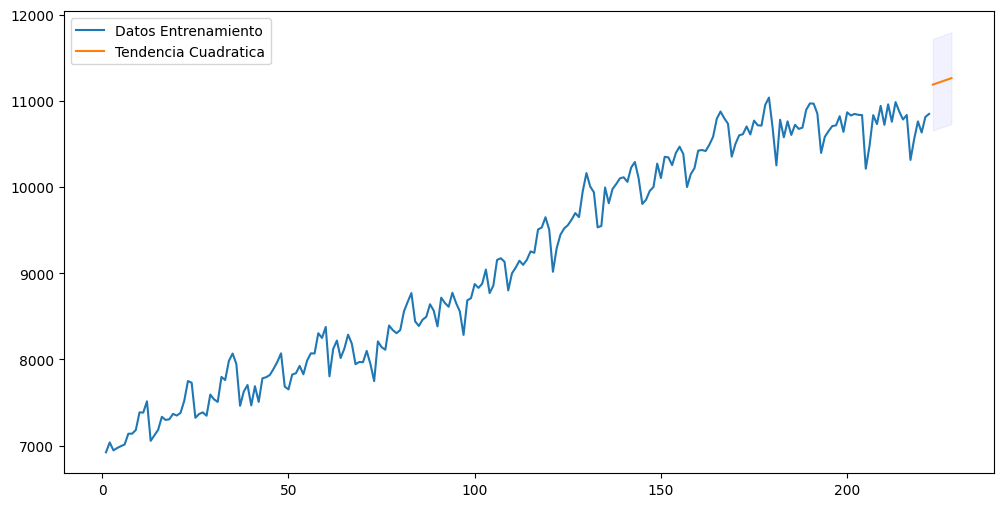

In [56]:
fig = plt.figure(figsize=(12, 6))
plt.plot(x,y,label="Datos Entrenamiento")
plt.plot(x_for,preds['Point_forecast'],label="Tendencia Cuadratica")
plt.fill_between(x_for ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.05)
plt.legend()
plt.show()

In [57]:
rmse_pol_2 = np.sqrt(mean_squared_error(test_Ocupados[:6], preds['Point_forecast']))
print(f"RMSE para la tendencia cuadrática: {rmse_pol_2}")

RMSE para la tendencia cuadrática: 592.8457992298231


### **Estimación de la Estacionalidad**

In [58]:
month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index)

y = data["Ocupados"]
X = sm.add_constant(month_dummies)
sea = sm.OLS(y,X.astype('int'))
season = sea.fit()
print(season.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                    0.2687
Date:                Thu, 19 Jun 2025   Prob (F-statistic):              0.991
Time:                        22:42:34   Log-Likelihood:                -1903.9
No. Observations:                 222   AIC:                             3832.
Df Residuals:                     210   BIC:                             3873.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8808.2176    302.768     29.092      0.0

In [59]:
month_dummies

,2,3,4,5,6,7,8,9,10,11,12
mes,,,,,,,,,,,
2001-01-01,False,False,False,False,False,False,False,False,False,False,False
2001-02-01,True,False,False,False,False,False,False,False,False,False,False
2001-03-01,False,True,False,False,False,False,False,False,False,False,False
2001-04-01,False,False,True,False,False,False,False,False,False,False,False
2001-05-01,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2019-02-01,True,False,False,False,False,False,False,False,False,False,False
2019-03-01,False,True,False,False,False,False,False,False,False,False,False
2019-04-01,False,False,True,False,False,False,False,False,False,False,False


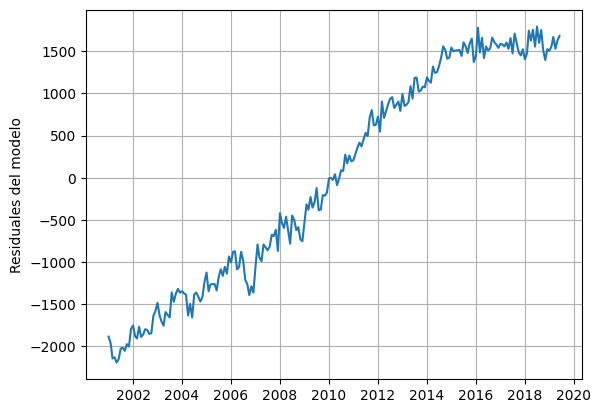

In [60]:
plt.ylabel("Residuales del modelo")
plt.plot(season.resid)
plt.grid()

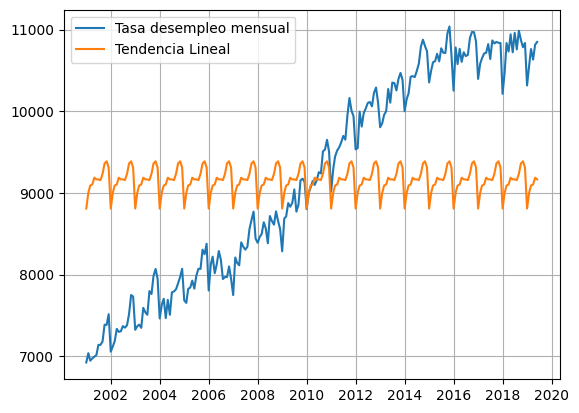

In [61]:
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(season.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [62]:
X_for=X_for.astype('int')

In [63]:
range_dates = pd.date_range(data.index[-1]+ relativedelta(months=1), periods=6,freq='MS')

x_for = pd.get_dummies(range_dates.month,drop_first=True)
X_for= sm.add_constant(x_for.astype('int'))

In [64]:
expected_cols = season.model.exog_names[1:]
future_months = range_dates.month
month_dummies_for = pd.get_dummies(future_months, drop_first=True)
month_dummies_for = month_dummies_for.reindex(columns=expected_cols, fill_value=0)

X_for = sm.add_constant(month_dummies_for)

print(X_for.columns.tolist())
print(season.model.exog_names)

['const', 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
['const', 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [65]:
expected_cols = season.model.exog_names[1:]
month_dummies_for = pd.get_dummies(range_dates.month, drop_first=True)
month_dummies_for = month_dummies_for.reindex(columns=expected_cols, fill_value=0)
X_for = sm.add_constant(month_dummies_for)

dt = season.get_prediction(X_for.astype(int)).summary_frame(alpha=0.05)

y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast     lower_95      upper_95
2019-07-01     8808.217632  6139.005354  11477.429909
2019-08-01     9156.633500  6483.716554  11829.550446
2019-09-01     9232.988500  6560.071554  11905.905446
2019-10-01     9359.934944  6687.017999  12032.851890
2019-11-01     9386.702222  6713.785277  12059.619168
2019-12-01     9310.332667  6637.415721  11983.249612


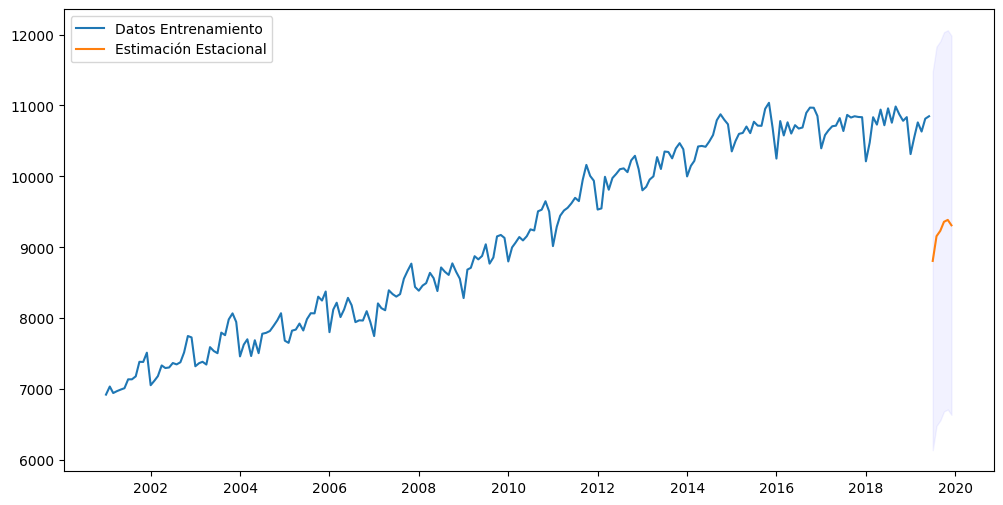

In [66]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.05)
plt.legend()
plt.show()

In [67]:
rmse_est = np.sqrt(mean_squared_error(test_Ocupados[:6], preds['Point_forecast']))
print(f"RMSE pronóstico 6 meses: {rmse_est}")


RMSE pronóstico 6 meses: 1448.1825858446332


### **Tendencia + Estacionalidad**

In [68]:
y = data["Ocupados"]
data["x"] = np.linspace(1,data.shape[0],data.shape[0])
data["x2"] = x**2

month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index)
X = sm.add_constant( pd.concat([data[["x","x2"]],month_dummies],axis=1) )

season_pol2 = sm.OLS(y,X.astype('int'))
season_pol_2 = season_pol2.fit()
print(season_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     502.6
Date:                Thu, 19 Jun 2025   Prob (F-statistic):          3.33e-149
Time:                        22:42:35   Log-Likelihood:                -1519.4
No. Observations:                 222   AIC:                             3067.
Df Residuals:                     208   BIC:                             3114.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6508.3401     69.460     93.700      0.0

In [69]:
X.astype('int')

,const,x,x2,2,3,4,5,6,7,8,9,10,11,12
mes,,,,,,,,,,,,,,
2001-01-01,1,1,1,0,0,0,0,0,0,0,0,0,0,0
2001-02-01,1,2,4,1,0,0,0,0,0,0,0,0,0,0
2001-03-01,1,3,9,0,1,0,0,0,0,0,0,0,0,0
2001-04-01,1,4,16,0,0,1,0,0,0,0,0,0,0,0
2001-05-01,1,5,25,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-01,1,218,47524,1,0,0,0,0,0,0,0,0,0,0
2019-03-01,1,219,47961,0,1,0,0,0,0,0,0,0,0,0
2019-04-01,1,220,48400,0,0,1,0,0,0,0,0,0,0,0


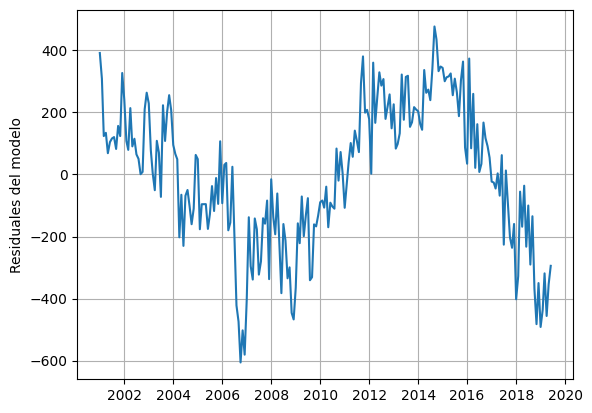

In [70]:
plt.ylabel("Residuales del modelo")
plt.plot(season_pol_2.resid)
plt.grid()

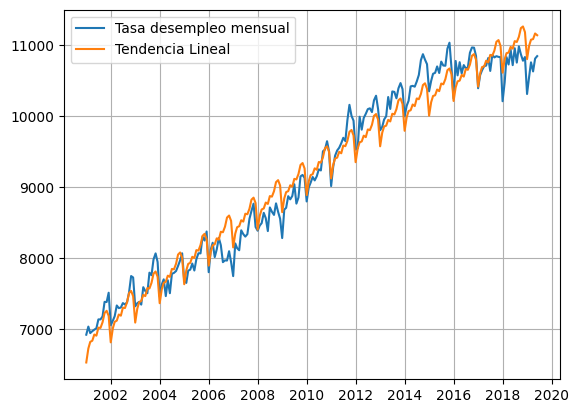

In [71]:
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(season_pol_2.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [72]:
X_for = X_for.astype(int)

In [73]:
data

,TD_13ciudades,Ocupados,Desocupados,Inactivos,x,x2
mes,,,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718,1.0,1.0
2001-02-01,19.894213,7037.746,1747.820,4596.805,2.0,4.0
2001-03-01,19.221565,6945.973,1652.823,4807.120,3.0,9.0
2001-04-01,17.888575,6973.079,1519.137,4937.280,4.0,16.0
2001-05-01,17.945654,6994.462,1529.720,4928.911,5.0,25.0
...,...,...,...,...,...,...
2019-02-01,12.427409,10557.917,1498.272,6264.403,218.0,47524.0
2019-03-01,11.975098,10760.776,1463.919,6116.140,219.0,47961.0
2019-04-01,11.144286,10632.028,1333.469,6395.575,220.0,48400.0


In [74]:
h=6
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2),axis=1),columns=["x","x2"] )
range_dates = pd.date_range(data.index[-1]+ relativedelta(months=1), periods=h,freq='MS')
x_for_dummies = pd.get_dummies(range_dates.month,drop_first=True)
X_for= sm.add_constant(pd.concat([x_for_all,x_for_dummies],axis=1))
X_for = X_for.astype(int)

In [75]:
X_for

,const,x,x2,8,9,10,11,12
0,1,223,49729,0,0,0,0,0
1,1,224,50176,1,0,0,0,0
2,1,225,50625,0,1,0,0,0
3,1,226,51076,0,0,1,0,0
4,1,227,51529,0,0,0,1,0
5,1,228,51984,0,0,0,0,1


In [76]:
expected_cols = season_pol_2.model.exog_names[1:]
month_dummies_for = pd.get_dummies(range_dates.month, drop_first=True)
month_dummies_for = month_dummies_for.reindex(columns=expected_cols, fill_value=0)

In [77]:
expected_cols = season_pol_2.model.exog_names[1:]

future_months = range_dates.month
month_dummies_for = pd.get_dummies(future_months, drop_first=True)

month_dummies_for = month_dummies_for.reindex(columns=expected_cols, fill_value=0)
X_for = sm.add_constant(month_dummies_for)


print(X_for.columns.tolist())
print(season_pol_2.model.exog_names)

['const', 'x', 'x2', 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
['const', 'x', 'x2', 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [78]:
expected_cols = season_pol_2.model.exog_names[1:]
month_dummies_for = pd.get_dummies(range_dates.month, drop_first=True)
month_dummies_for = month_dummies_for.reindex(columns=expected_cols, fill_value=0)
X_for = sm.add_constant(month_dummies_for)

dt = season_pol_2.get_prediction(X_for.astype(int)).summary_frame(alpha=0.05)

y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast     lower_95     upper_95
2019-07-01     6508.340098  6026.064670  6990.615525
2019-08-01     6828.575327  6345.045565  7312.105090
2019-09-01     6885.201984  6401.616052  7368.787916
2019-10-01     6992.457988  6508.817943  7476.098033
2019-11-01     6999.572728  6515.880626  7483.264831
2019-12-01     6903.588538  6419.846431  7387.330645


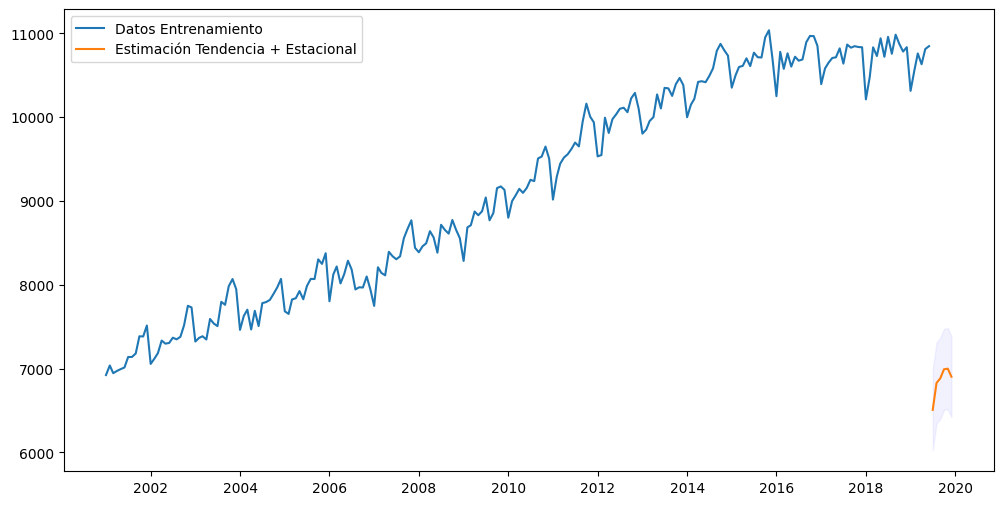

In [79]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Tendencia + Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.05)
plt.legend()
plt.show()

In [80]:
rmse_estt = np.sqrt(mean_squared_error(test_Ocupados[:6], preds['Point_forecast']))
print(f"RMSE pronóstico 6 meses: {rmse_estt:.4f}")

RMSE pronóstico 6 meses: 3802.6641


In [81]:
rmse_results = pd.DataFrame({
    "Modelo": ["Tendencia Lineal", "Tendencia Cuadrática", "Estacionalidad", "Tendencia + Estacionalidad"],
    "RMSE": [rmse_lin, rmse_pol_2, rmse_est, rmse_estt]
})
print("\nComparación de RMSE por modelo:")
print(rmse_results.sort_values(by="RMSE"))


Comparación de RMSE por modelo:
                       Modelo         RMSE
1        Tendencia Cuadrática   592.845799
0            Tendencia Lineal   769.560605
2              Estacionalidad  1448.182586
3  Tendencia + Estacionalidad  3802.664060


# **Taller 2 Solucion**

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses empleando los métodos vistos en la clase. Compare
los resultados con el mejor modelo encontrado en el ejercicio anterior.

Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

In [82]:
train_len = 216

train_month_dummies = month_dummies[:train_len].copy()
test_month_dummies = month_dummies[train_len:].copy()

train_data = pd.concat([data.iloc[:train_len], train_month_dummies.astype(int)], axis=1).copy()
test_data = pd.concat([data.iloc[train_len:], test_month_dummies.astype(int)], axis=1).copy()

print(train_data.head())
print(test_data.head())

            TD_13ciudades  Ocupados  Desocupados  Inactivos    x    x2  2  3  \
mes                                                                            
2001-01-01      20.946380  6923.604     1834.507   4600.718  1.0   1.0  0  0   
2001-02-01      19.894213  7037.746     1747.820   4596.805  2.0   4.0  1  0   
2001-03-01      19.221565  6945.973     1652.823   4807.120  3.0   9.0  0  1   
2001-04-01      17.888575  6973.079     1519.137   4937.280  4.0  16.0  0  0   
2001-05-01      17.945654  6994.462     1529.720   4928.911  5.0  25.0  0  0   

            4  5  6  7  8  9  10  11  12  
mes                                       
2001-01-01  0  0  0  0  0  0   0   0   0  
2001-02-01  0  0  0  0  0  0   0   0   0  
2001-03-01  0  0  0  0  0  0   0   0   0  
2001-04-01  1  0  0  0  0  0   0   0   0  
2001-05-01  0  1  0  0  0  0   0   0   0  
            TD_13ciudades   Ocupados  Desocupados  Inactivos      x       x2  \
mes                                                       

### **Tendencia lineal**

In [83]:
# Modelo de tendencia lineal
y_train_lin = train_data["Ocupados"]
x_train_lin = np.linspace(1, train_data.shape[0], train_data.shape[0])
X_train_lin = sm.add_constant(x_train_lin)
lin = sm.OLS(y_train_lin, X_train_lin)
lin_t = lin.fit()


In [84]:
x_test_lin = np.linspace(train_data.shape[0] + 1, data.shape[0], test_data.shape[0])
X_test_lin = sm.add_constant(x_test_lin)
lin_forecast = lin_t.predict(X_test_lin)

In [85]:
# Obtener predicciones con intervalos de confianza
dt = lin_t.get_prediction(X_test_lin).summary_frame(alpha=0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]), columns=['Point_forecast', 'lower_95', 'upper_95'])
print(preds.head(6))

   Point_forecast      lower_95      upper_95
0    11313.116341  10810.849071  11815.383612
1    11333.335242  10831.003977  11835.666506
2    11353.554142  10851.158304  11855.949979
3    11373.773042  10871.312053  11876.234030
4    11393.991942  10891.465223  11896.518660
5    11414.210842  10911.617816  11916.803868


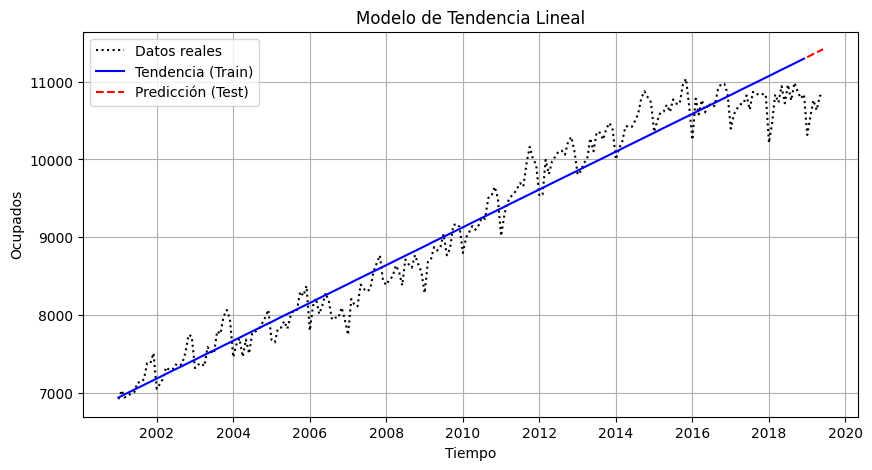

In [86]:
# Gráfico del modelo de tendencia lineal
plt.figure(figsize=(10,5))

# Datos reales
plt.plot(data.index, data["Ocupados"], label="Datos reales", color="black", linestyle="dotted")

# Tendencia lineal en entrenamiento
plt.plot(train_data.index, lin_t.predict(X_train_lin), label="Tendencia (Train)", color="blue")

# Predicción en test
plt.plot(test_data.index, lin_forecast, label="Predicción (Test)", color="red", linestyle="dashed")

plt.xlabel("Tiempo")
plt.ylabel("Ocupados")
plt.title("Modelo de Tendencia Lineal")
plt.legend()
plt.grid()

plt.show()

In [87]:
rmse_lineal = np.sqrt(mean_squared_error(test_data["Ocupados"], lin_forecast))
print(f"RMSE para el modelo de tendencia lineal: {rmse_lineal}")

RMSE para el modelo de tendencia lineal: 725.5285275153046


In [88]:
# Crear variable de tendencia (tiempo)
train_data['t'] = np.arange(1, len(train_data) + 1)
test_data['t'] = np.arange(len(train_data) + 1, len(data) + 1)

# Variables predictoras: tendencia + dummies
X_train_lin = sm.add_constant(train_data[['t'] + list(train_month_dummies.columns)])
X_test_lin = sm.add_constant(test_data[['t'] + list(test_month_dummies.columns)])

# Ajustar modelo
lin = sm.OLS(train_data["Ocupados"], X_train_lin)
lin_t = lin.fit()

# Predicción y evaluación
lin_forecast = lin_t.predict(X_test_lin)
rmse_lineal = np.sqrt(mean_squared_error(test_data["Ocupados"], lin_forecast))
print(f"RMSE mejorado (tendencia + dummies): {rmse_lineal}")


RMSE mejorado (tendencia + dummies): 614.2159752377593


In [89]:
# Transformación logarítmica si hay crecimiento exponencial
train_data["log_ocupados"] = np.log(train_data["Ocupados"])
test_data["log_ocupados"] = np.log(test_data["Ocupados"])


In [90]:
features = ['t'] + list(train_month_dummies.columns)
X_train = sm.add_constant(train_data[features])
X_test = sm.add_constant(test_data[features])
y_train = train_data["Ocupados"]

# Modelo ajustado
model = sm.OLS(y_train, X_train).fit()

# Predicción y error
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(test_data["Ocupados"], y_pred))
print(f"Nuevo RMSE con dummies y tendencia: {rmse}")


Nuevo RMSE con dummies y tendencia: 614.2159752377593


El modelo lineal (614.219) y el cuadrático (632.48) tienen un desempeño razonable pero notablemente inferior al cúbico

### **Tendencia cuadratica**

In [91]:
y_train_pol = train_data["Ocupados"]
train_data["x"] = np.linspace(1, train_data.shape[0], train_data.shape[0])
train_data["x2"] = train_data["x"]**2
X_train_pol = sm.add_constant(train_data[["x", "x2"]])
pol = sm.OLS(y_train_pol, X_train_pol)
pol_2 = pol.fit()

In [92]:
test_data["x"] = np.linspace(train_data.shape[0] + 1, data.shape[0], test_data.shape[0])
test_data["x2"] = test_data["x"]**2
X_test_pol = sm.add_constant(test_data[["x", "x2"]])
pol2_forecast = pol_2.predict(X_test_pol)

In [93]:
dt = pol_2.get_prediction(X_test_pol).summary_frame(alpha=0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]), columns=['Point_forecast', 'lower_95', 'upper_95'])
print(preds.head(6))

   Point_forecast      lower_95      upper_95
0    11223.006575  10720.110033  11725.903118
1    11240.733961  10737.453096  11744.014826
2    11258.438489  10754.761188  11762.115790
3    11276.120159  10772.034093  11780.206225
4    11293.778971  10789.271596  11798.286346
5    11311.414925  10806.473482  11816.356368


In [94]:
train_data['t'] = train_data['t'] / len(train_data)
train_data['t2'] = train_data['t'] ** 2

test_data['t'] = test_data['t'] / len(train_data)
test_data['t2'] = test_data['t'] ** 2

X_train_quad = sm.add_constant(train_data[['t', 't2']])
y_train_quad = train_data["Ocupados"]

X_test_quad = sm.add_constant(test_data[['t', 't2']])
y_test_quad = test_data["Ocupados"]

model_quad = sm.OLS(y_train_quad, X_train_quad).fit()

y_pred_quad = model_quad.predict(X_test_quad)

dt_quad = model_quad.get_prediction(X_test_quad).summary_frame(alpha=0.05)
preds_quad = dt_quad[['mean', 'obs_ci_lower', 'obs_ci_upper']]
preds_quad.columns = ['Point_forecast', 'lower_95', 'upper_95']

print(preds_quad.head(6))


            Point_forecast      lower_95      upper_95
mes                                                   
2019-01-01    11223.006575  10720.110033  11725.903118
2019-02-01    11240.733961  10737.453096  11744.014826
2019-03-01    11258.438489  10754.761188  11762.115790
2019-04-01    11276.120159  10772.034093  11780.206225
2019-05-01    11293.778971  10789.271596  11798.286346
2019-06-01    11311.414925  10806.473482  11816.356368


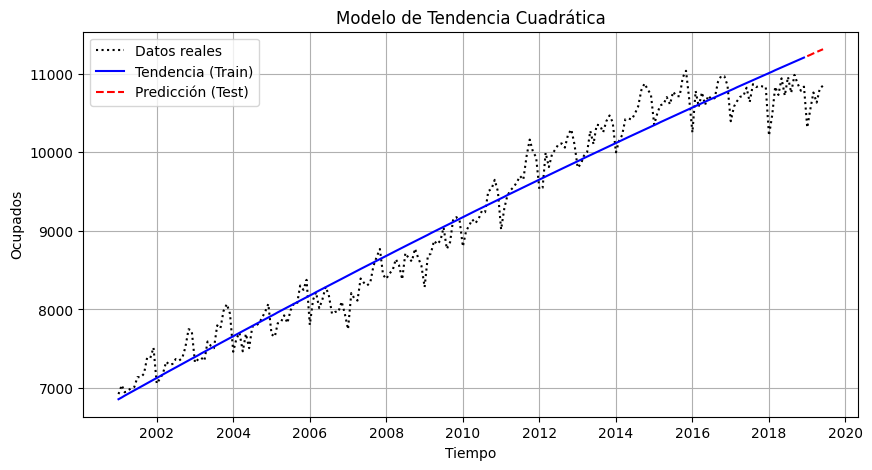

In [95]:
plt.figure(figsize=(10,5))
plt.plot(data.index, data["Ocupados"], label="Datos reales", color="black", linestyle="dotted")
plt.plot(train_data.index, pol_2.predict(X_train_pol), label="Tendencia (Train)", color="blue")
plt.plot(test_data.index, pol2_forecast, label="Predicción (Test)", color="red", linestyle="dashed")
plt.xlabel("Tiempo")
plt.ylabel("Ocupados")
plt.title("Modelo de Tendencia Cuadrática")
plt.legend()
plt.grid()

plt.show()

In [96]:
rmse_quad = np.sqrt(mean_squared_error(y_test_quad, y_pred_quad))
print(f"RMSE para el modelo de tendencia cuadrática: {rmse_quad}")

RMSE para el modelo de tendencia cuadrática: 632.4766573069285


Los modelos lineales y cuadráticos no fueron capaces de representar el patrón creciente de los ocupados, resultando en errores altos.

### **Tendencia cubica**

In [97]:
# Variables de tendencia cúbica
train_data["x"] = np.arange(1, len(train_data) + 1)
train_data["x2"] = train_data["x"] ** 2
train_data["x3"] = train_data["x"] ** 3

test_data["x"] = np.arange(len(train_data) + 1, len(train_data) + len(test_data) + 1)
test_data["x2"] = test_data["x"] ** 2
test_data["x3"] = test_data["x"] ** 3

# Crear variables X y y
X_train_cubic = sm.add_constant(train_data[["x", "x2", "x3"]], has_constant='add')
y_train_cubic = train_data["Ocupados"]

X_test_cubic = sm.add_constant(test_data[["x", "x2", "x3"]], has_constant='add')
y_test_cubic = test_data["Ocupados"]


In [98]:
# Entrenar modelo cúbico
model_cubic = sm.OLS(y_train_cubic, X_train_cubic).fit()

# Predicciones con intervalos
dt = model_cubic.get_prediction(X_test_cubic).summary_frame(alpha=0.05)

# Extraer predicciones
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

# Crear DataFrame de resultados
preds = pd.DataFrame(
    np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]),
    columns=['Point_forecast', 'lower_95', 'upper_95'],
    index=test_data.index
)

# Mostrar resultados
print(preds.head(6))


            Point_forecast      lower_95      upper_95
mes                                                   
2019-01-01    10811.417558  10405.366847  11217.468269
2019-02-01    10806.384261  10399.300100  11213.468423
2019-03-01    10800.806072  10392.623991  11208.988153
2019-04-01    10794.678224  10385.331151  11204.025296
2019-05-01    10787.995948  10377.414174  11198.577723
2019-06-01    10780.754479  10368.865618  11192.643339


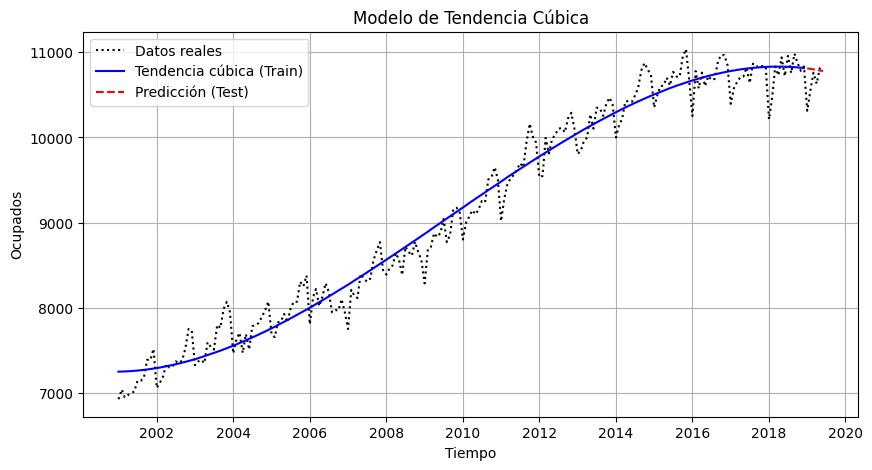

In [99]:
plt.figure(figsize=(10, 5))
plt.plot(data.index, data["Ocupados"], label="Datos reales", color="black", linestyle="dotted")
plt.plot(train_data.index, model_cubic.predict(X_train_cubic), label="Tendencia cúbica (Train)", color="blue")
plt.plot(test_data.index, y_prd, label="Predicción (Test)", color="red", linestyle="dashed")

plt.xlabel("Tiempo")
plt.ylabel("Ocupados")
plt.title("Modelo de Tendencia Cúbica")
plt.legend()
plt.grid()

plt.show()


In [100]:
rmse_cubic = np.sqrt(mean_squared_error(y_test_cubic, y_prd))
print(f"RMSE para el modelo de tendencia cúbica: {rmse_cubic}")

RMSE para el modelo de tendencia cúbica: 238.72205796218773


El modelo cúbico logró capturar adecuadamente el crecimiento no lineal de la serie.

 muestra que la serie tiene una tendencia no lineal clara

### **Estacionalidad**

In [101]:
y_train_sea = train_data["Ocupados"]
month_dummies_train = pd.get_dummies(train_data.index.month, drop_first=True).set_index(train_data.index)
X_train_sea = sm.add_constant(month_dummies_train).astype(float)
sea = sm.OLS(y_train_sea, X_train_sea)
season = sea.fit()

In [102]:
expected_cols = season.model.exog_names[1:]
month_dummies_test = pd.get_dummies(test_data.index.month, drop_first=True)
month_dummies_test = month_dummies_test.reindex(columns=expected_cols, fill_value=0)
X_test_sea = sm.add_constant(month_dummies_test).astype(float)
season_forecast = season.predict(X_test_sea)

print(season_forecast)

0    8724.538722
1    8914.544389
2    8997.218333
3    9017.681722
4    9095.089000
5    9071.789000
dtype: float64


In [103]:
# Predicciones con intervalos de confianza
dt = season.get_prediction(X_test_sea).summary_frame(alpha=0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]), columns=['Point_forecast', 'lower_95', 'upper_95'])
print(preds.head(6))

   Point_forecast     lower_95      upper_95
0     8724.538722  6072.708767  11376.368678
1     8914.544389  6262.714433  11566.374344
2     8997.218333  6345.388378  11649.048289
3     9017.681722  6365.851767  11669.511678
4     9095.089000  6443.259045  11746.918955
5     9071.789000  6419.959045  11723.618955


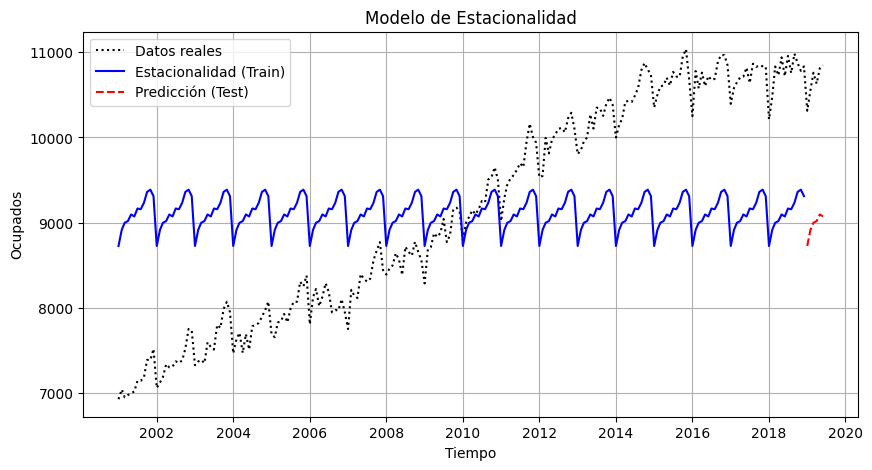

In [104]:
plt.figure(figsize=(10,5))
plt.plot(data.index, data["Ocupados"], label="Datos reales", color="black", linestyle="dotted")
plt.plot(train_data.index, season.predict(X_train_sea), label="Estacionalidad (Train)", color="blue")
plt.plot(test_data.index, season_forecast, label="Predicción (Test)", color="red", linestyle="dashed")
plt.xlabel("Tiempo")
plt.ylabel("Ocupados")
plt.title("Modelo de Estacionalidad")
plt.legend()
plt.grid()

plt.show()

In [105]:
rmse_season = np.sqrt(mean_squared_error(test_data["Ocupados"], season_forecast))
print(f"RMSE para el modelo de estacionalidad: {rmse_season}")

RMSE para el modelo de estacionalidad: 1685.7662214902105


Aunque el modelo de estacionalidad capta las variaciones mensuales, ignora la tendencia creciente, por lo que no es útil para predicción de largo plazo.

### **Cubica + Estacionalidad**

In [106]:
train_data["x"] = np.arange(1, len(train_data) + 1)
train_data["x2"] = train_data["x"] ** 2
train_data["x3"] = train_data["x"] ** 3

test_data["x"] = np.arange(len(train_data) + 1, len(train_data) + len(test_data) + 1)
test_data["x2"] = test_data["x"] ** 2
test_data["x3"] = test_data["x"] ** 3

month_dummies = pd.get_dummies(data.index.month, prefix="mes", drop_first=False)

train_month_dummies = month_dummies.iloc[:len(train_data)].copy()
test_month_dummies = month_dummies.iloc[len(train_data):].copy()

train_month_dummies.index = train_data.index
test_month_dummies.index = test_data.index
test_month_dummies = test_month_dummies.reindex(columns=train_month_dummies.columns, fill_value=0)

X_train = sm.add_constant(pd.concat([train_data[["x", "x2", "x3"]], train_month_dummies], axis=1)).astype(float)
y_train = train_data["Ocupados"]

X_test = sm.add_constant(pd.concat([test_data[["x", "x2", "x3"]], test_month_dummies], axis=1)).astype(float)
y_test = test_data["Ocupados"]


model_comb = sm.OLS(y_train, X_train).fit()
y_pred = model_comb.predict(X_test)


In [107]:
dt = model_comb.get_prediction(X_test).summary_frame(alpha=0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

preds = pd.DataFrame(
    np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]),
    columns=['Point_forecast', 'lower_95', 'upper_95'],
    index=test_data.index)

print(preds.head(6))


            Point_forecast      lower_95      upper_95
mes                                                   
2019-01-01    10466.696419  10148.714219  10784.678620
2019-02-01    10633.804522  10315.146081  10952.462964
2019-03-01    10693.000989  10373.626993  11012.374985
2019-04-01    10689.406986  10369.276574  11009.537397
2019-05-01    10742.176957  10421.247701  11063.106213
2019-06-01    10693.659737  10371.887621  11015.431853


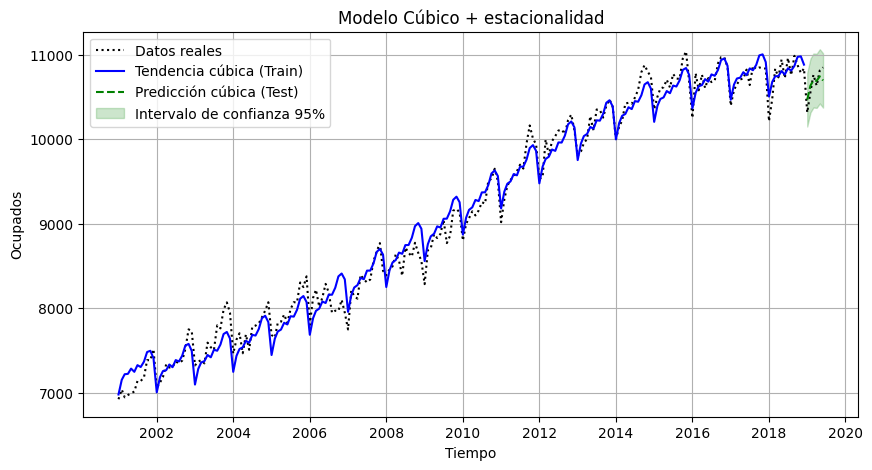

In [108]:
plt.figure(figsize=(10,5))

# Datos reales
plt.plot(data.index, data["Ocupados"], label="Datos reales", color="black", linestyle="dotted")

# Tendencia cúbica en azul (Train)
plt.plot(train_data.index, model_comb.predict(X_train), label="Tendencia cúbica (Train)", color="blue", linestyle="solid")

# Predicción cúbica en verde (Test)
plt.plot(test_data.index, preds["Point_forecast"], label="Predicción cúbica (Test)", color="green", linestyle="dashed")

# Intervalos de confianza
plt.fill_between(test_data.index, preds["lower_95"], preds["upper_95"], color="green", alpha=0.2, label="Intervalo de confianza 95%")

plt.xlabel("Tiempo")
plt.ylabel("Ocupados")
plt.title("Modelo Cúbico + estacionalidad")
plt.legend()
plt.grid()
# Guardar como imagen
plt.savefig("mejor.png", dpi=300, bbox_inches="tight")

plt.show()

In [109]:
# Calcular RMSE
rmse_cu_es = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE para modelo cúbico + estacionalidad: {rmse_cu_es}")

RMSE para modelo cúbico + estacionalidad: 104.61370410042329


El modelo cúbico + estacionalidad fue claramente el más acertado, ya que representó tanto el patrón de crecimiento acelerado como las fluctuaciones cíclicas mensuales.

Este modelo es más robusto y preciso para representar la dinámica temporal de la serie.

### **Tendencia + Estacionalidad**

In [110]:
y_train_seaspol = train_data["Ocupados"]
X_train_seaspol = sm.add_constant(pd.concat([train_data[["x", "x2"]], month_dummies_train], axis=1)).astype(float) # Convertir a float
season_pol2 = sm.OLS(y_train_seaspol, X_train_seaspol)
season_pol_2 = season_pol2.fit()

In [111]:
X_test_seaspol = sm.add_constant(pd.concat([test_data[["x", "x2"]], month_dummies_test], axis=1)).astype(float) # Convertir a float
season_pol2_forecast = season_pol_2.predict(X_test_seaspol)

/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)


In [112]:
# Definir las columnas esperadas
expected_cols = season_pol_2.model.exog_names[1:]

# Generar las dummies para los meses futuros
future_months = range_dates.month
month_dummies_for = pd.get_dummies(future_months, drop_first=True)

# Asegurar que las columnas coincidan con las esperadas
month_dummies_for = month_dummies_for.reindex(columns=expected_cols, fill_value=0)

# Agregar constante para el modelo
X_for = sm.add_constant(month_dummies_for)

# Predicción con el modelo
dt = season_pol_2.get_prediction(X_for.astype(int)).summary_frame(alpha=0.05)

y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]), columns=['Point_forecast', 'lower_95', 'upper_95'])
preds.set_index(range_dates, inplace=True)

print(preds)

            Point_forecast     lower_95     upper_95
2019-07-01     6562.020397  6098.950252  7025.090543
2019-08-01     6852.925993  6389.442576  7316.409410
2019-09-01     6909.202358  6445.668141  7372.736574
2019-10-01     7016.092979  6552.510018  7479.675940
2019-11-01     7022.827246  6559.197588  7486.456904
2019-12-01     6926.447491  6462.773177  7390.121806


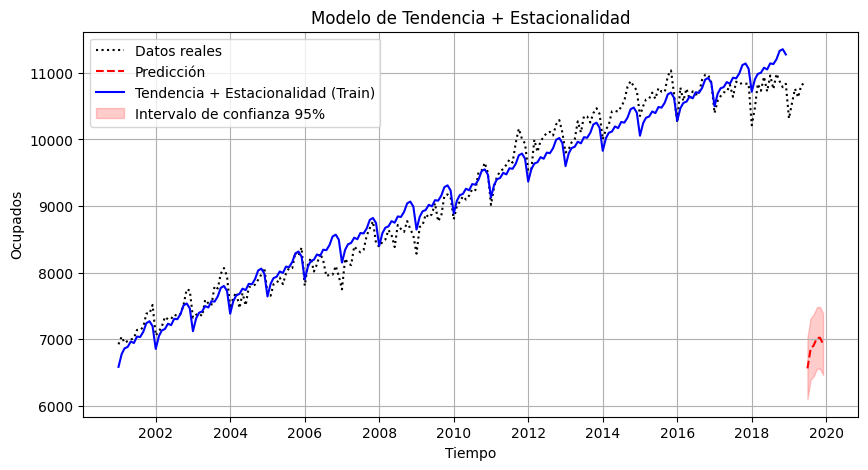

In [113]:
plt.figure(figsize=(10,5))

plt.plot(data.index, data["Ocupados"], label="Datos reales", color="black", linestyle="dotted")

# Predicción basada en el modelo season_pol_2
plt.plot(range_dates, preds["Point_forecast"], label="Predicción", color="red", linestyle="dashed")

# Intervalos de confianza
plt.plot(train_data.index, season_pol_2.predict(X_train_seaspol), label="Tendencia + Estacionalidad (Train)", color="blue")
plt.fill_between(range_dates, preds["lower_95"], preds["upper_95"], color="red", alpha=0.2, label="Intervalo de confianza 95%")

plt.xlabel("Tiempo")
plt.ylabel("Ocupados")
plt.title("Modelo de Tendencia + Estacionalidad")
plt.legend()
plt.grid()

plt.show()

In [114]:
 rmse_season_pol2 = np.sqrt(mean_squared_error(test_data["Ocupados"], preds["Point_forecast"]))
print(f"RMSE para la tendencia + estacionalidad: { rmse_season_pol2}")

RMSE para la tendencia + estacionalidad: 3774.060267381052


El modelo lineal + estacionalidad resultó incoherente, mostrando un RMSE inusualmente alto de 3774 ocupados, probablemente por sobreajuste o interacción no lineal mal representada.

## **Resultados**

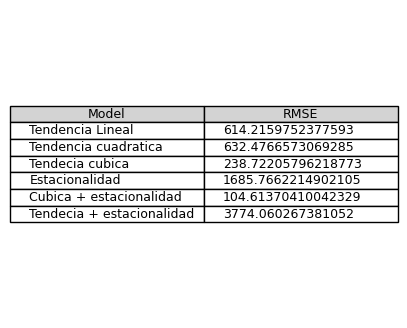

In [115]:
RMSE = pd.DataFrame({
    'Model': ['Tendencia Lineal', 'Tendencia cuadratica','Tendecia cubica',  'Estacionalidad', 'Cubica + estacionalidad','Tendecia + estacionalidad'],
    'RMSE': [rmse_lineal, rmse_quad, rmse_cubic, rmse_season, rmse_cu_es,rmse_season_pol2]
})
df = pd.DataFrame(RMSE)

fig, ax = plt.subplots(figsize=(5, 4))
ax.axis("tight")
ax.axis("off")

tabla = ax.table(cellText=df.values, colLabels=df.columns, cellLoc="left", loc="center",
                 colColours=["lightgray"] * df.shape[1])
tabla.auto_set_font_size(False)
tabla.set_fontsize(9)

# Guardar como imagen
plt.savefig("Resultados_tabla2.png", dpi=300, bbox_inches="tight")
plt.show()

**Conslusiones**
El modelo cuadrático con estacionalidad mensual, ha demostrado ser el más adecuado tanto desde el punto de vista teórico como en los resultados obtenidos. Modelos más simples, como la tendencia lineal o la estacionalidad por sí sola, han mostrado errores elevados, lo que evidencia que no son suficientes para capturar la dinámica de los datos. En contraste, el modelo cúbico-estacional ha logrado el RMSE más bajo (104.61), lo que indica una mayor precisión en sus predicciones. Además, la incorporación de variables dummies para representar los meses ha sido clave para reflejar explícitamente la estacionalidad, permitiendo que el modelo capture mejor las fluctuaciones a lo largo del tiempo. Sin embargo este modelo con cumple con el objetivo de un RMSE inferior al Suavización Holt-Winters Aditivo de 75 ocupados aproximadamente.

# **Taller 3**

### **ACF y PACF**

In [116]:
#borrar de dato x y x2
data = data.drop(columns=['x', 'x2'])

In [117]:
acf(data['Ocupados'],40)

array([1.        , 0.97855484, 0.96290943, 0.94999592, 0.93767278,
       0.92828634, 0.91803512, 0.90827078, 0.89628125, 0.88592368,
       0.8772359 , 0.8728291 , 0.86780346, 0.84936325, 0.83206921,
       0.81773834, 0.80588679, 0.79695724, 0.78708534, 0.77639894,
       0.76345987, 0.75177965, 0.74296472, 0.73663393, 0.73128083,
       0.71333785, 0.69520217, 0.68008434, 0.66685076, 0.65659735,
       0.64390143, 0.63170587, 0.6184013 , 0.60541159, 0.59596135,
       0.58936238, 0.5824738 , 0.56326155, 0.54546119, 0.53051481,
       0.51728811])

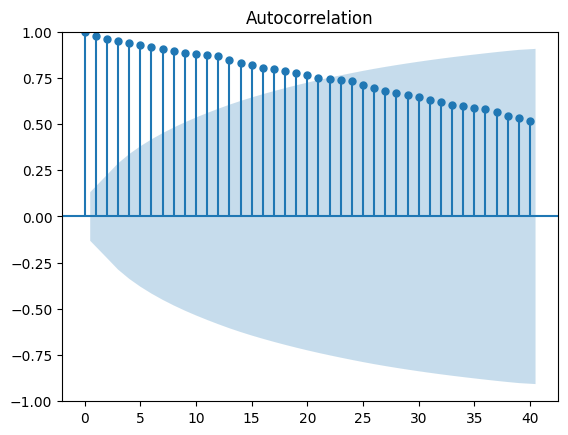

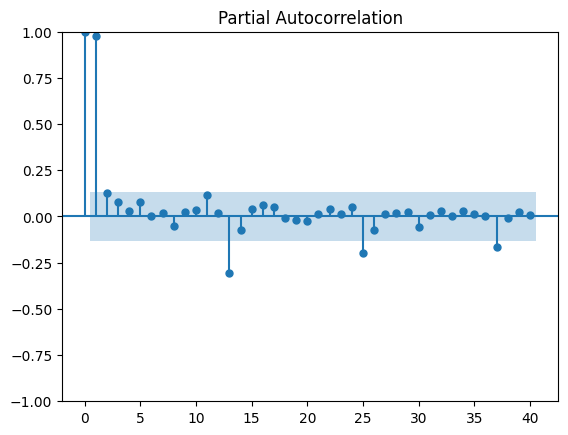

In [118]:
plot_acf(data['Ocupados'],lags=40);
plot_pacf(data['Ocupados'],lags=40);

In [119]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Ajustar modelo SARIMAX(0,1,1) SIN estacionalidad
model = SARIMAX(train_Ocupados, order=(0,1,1), seasonal_order=(0,0,0,0), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Mostrar resumen completo
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:               Ocupados   No. Observations:                  216
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1410.314
Date:                Thu, 19 Jun 2025   AIC                           2824.627
Time:                        22:42:40   BIC                           2831.350
Sample:                    01-01-2001   HQIC                          2827.344
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3672      0.072     -5.134      0.000      -0.507      -0.227
sigma2        3.3e+04   2656.573     12.424      0.000    2.78e+04    3.82e+04
Ljung-Box (L1) (Q):                   0.48   Jarque-

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [120]:
# Ajustar modelo SARIMAX(0,1,1) SIN estacionalidad
model = auto_arima(data["Ocupados"],max_p=10, max_q=10,information_criterion = ("aic"))
model.summary()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  222
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1451.595
Date:                Thu, 19 Jun 2025   AIC                           2911.190
Time:                        22:42:42   BIC                           2924.782
Sample:                    01-01-2001   HQIC                          2916.678
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.8551      2.485      3.965      0.000       4.984      14.726
ar.L1          0.4419      0.101      4.357      0.000       0.243       0.641
ma.L1         -0.8618      0.053    -16.414      0.000      -0.965      -0.759
sigma2      2.948e+04   2480.399     11.885      0.000    2.46e+04    3.43e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                57.86
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                            -0.99
Prob(H) (two-sided):                  0.28   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [121]:
model.resid()

,0
mes,
2001-01-01,6905.945665
2001-02-01,159.981703
2001-03-01,-38.696293
2001-04-01,28.345019
2001-05-01,22.031181
...,...
2019-02-01,-33.944119
2019-03-01,56.155412
2019-04-01,-179.849548


Text(0.5, 1.0, 'Residuales de Ocupados')

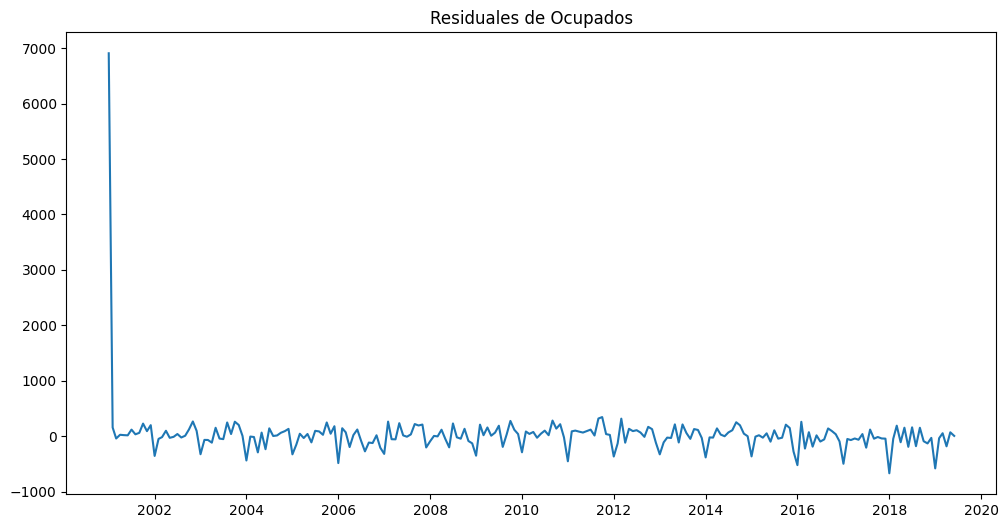

In [122]:
fig = plt.figure(figsize=(12, 6))
plt.plot(model.resid(),label="Residuales")
#titulo a la gradica residuales de Ocupados
plt.title("Residuales de Ocupados")


### **Pronóstico del ARIMA(0,1,1) obtenido en el auto.arima**


In [123]:
data

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911
...,...,...,...,...
2019-02-01,12.427409,10557.917,1498.272,6264.403
2019-03-01,11.975098,10760.776,1463.919,6116.140
2019-04-01,11.144286,10632.028,1333.469,6395.575


In [124]:
data = data.reset_index()

In [125]:
data.index

RangeIndex(start=0, stop=222, step=1)

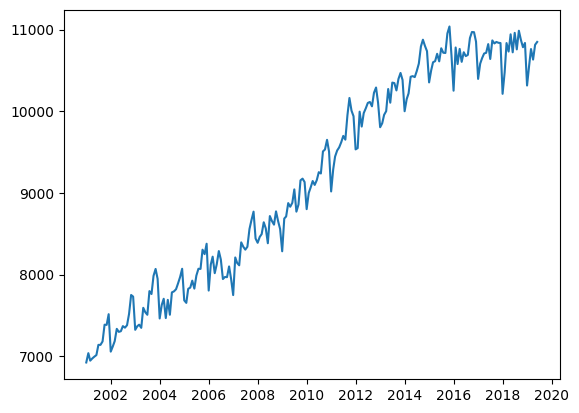

In [126]:
plt.plot(data["mes"], data["Ocupados"])

In [127]:
data.index = pd.to_datetime(data.index)

In [128]:
import numpy as np
import pandas as pd

h = 6  # horizonte de pronóstico

# Bootstrap de residuos directamente desde model.resid()
my_samples = []
for _ in range(1000):
    x = np.random.choice(np.asarray(model.resid()), size=h, replace=True)
    my_samples.append(x)

# Cuantiles del bootstrap
q1 = np.quantile(my_samples, 0.025, axis=0)
q2 = np.quantile(my_samples, 0.975, axis=0)

# Pronóstico puntual
y_forec, _ = model.predict(h, return_conf_int=True, alpha=0.05)

# Crear índice mensual futuro
last_date = data.index[-1]
forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=h, freq='MS')

# Construir DataFrame con pronóstico e intervalos de confianza simulados
preds = pd.DataFrame(
    np.column_stack([y_forec, y_forec + np.cumsum(q1), y_forec + np.cumsum(q2)]),
    columns=['Point_forecast', 'lower_95', 'upper_95'],
    index=forecast_index
)

print(preds)

                               Point_forecast      lower_95      upper_95
1970-02-01 00:00:00.000000221    10866.345100  10431.511382  11131.957462
1970-03-01 00:00:00.000000221    10884.306918  10014.639482  11418.229643
1970-04-01 00:00:00.000000221    10902.099363   9550.457014  11754.818816
1970-05-01 00:00:00.000000221    10919.816962   9186.725666  12038.148777
1970-06-01 00:00:00.000000221    10937.501485   8755.073392  12340.362256
1970-07-01 00:00:00.000000221    10955.171393   8323.406501  12642.561120


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [129]:
h=6

y_forec, conf_int  = model.predict(h,return_conf_int=True,alpha=0.05)
preds = pd.DataFrame(
    np.column_stack([y_forec, y_forec + np.cumsum(q1), y_forec + np.cumsum(q2)]),
    columns=['Point_forecast', 'lower_95', 'upper_95'],
    index=test_data.index  # Asegúrate de que test_data.index tenga longitud h
)
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
# Mostrar resultados
print(preds.head(6))


            Point_forecast      lower_95      upper_95
mes                                                   
2019-01-01    10866.345100  10431.511382  11131.957462
2019-02-01    10884.306918  10014.639482  11418.229643
2019-03-01    10902.099363   9550.457014  11754.818816
2019-04-01    10919.816962   9186.725666  12038.148777
2019-05-01    10937.501485   8755.073392  12340.362256
2019-06-01    10955.171393   8323.406501  12642.561120


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


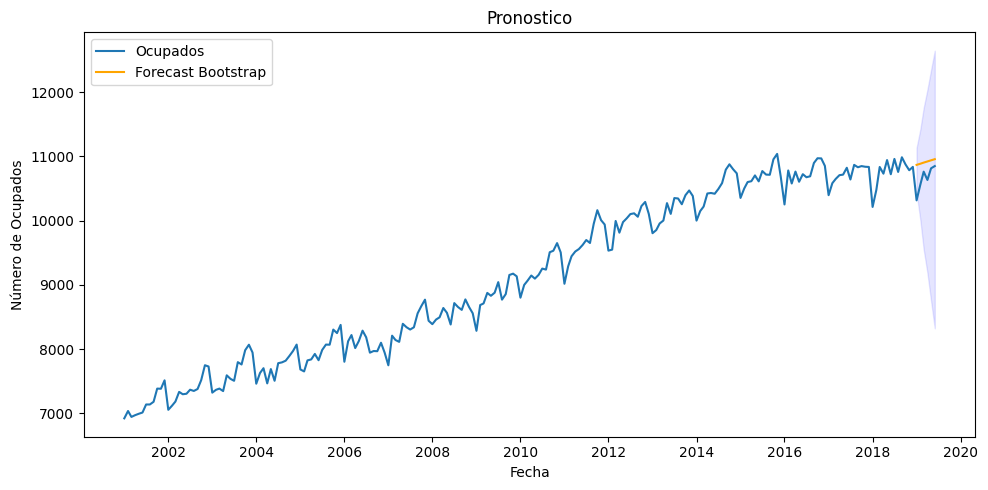

In [130]:
#fig = plt.figure(figsize=(12, 6))
#plt.plot(data["mes"],data["Ocupados"],label="Ocupados")
#plt.plot(x_for,preds['Point_forecast'],label="Forecast Ocupados")
#plt.fill_between(x_for,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
#plt.title("Pronostico")
#plt.legend()
#plt.show()

fig = plt.figure(figsize=(10, 5))

plt.plot(data["mes"],data["Ocupados"],label="Ocupados")
plt.plot(preds.index, preds['Point_forecast'], label="Forecast Bootstrap", color='orange')
plt.fill_between(preds.index, preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.xlabel("Fecha")
plt.ylabel("Número de Ocupados")
plt.title("Pronostico")
plt.tight_layout()
plt.show()


### **Replicando el modelo sin hacer auto arima**

In [131]:
model = ARIMA(order=(0,1,1))
results = model.fit( data["Ocupados"])
results.summary()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  222
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1462.336
Date:                Thu, 19 Jun 2025   AIC                           2930.671
Time:                        22:42:44   BIC                           2940.866
Sample:                    01-01-1970   HQIC                          2934.787
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     17.7453      8.479      2.093      0.036       1.128      34.363
ma.L1         -0.4462      0.068     -6.591      0.000      -0.579      -0.314
sigma2      3.257e+04   2830.389     11.507      0.000     2.7e+04    3.81e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.30   Jarque-Bera (JB):                80.12
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -1.17
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## **Intervalos de confianza usando boostrap**


In [132]:
h= 6
res = results.resid()

my_samples = []
for _ in range(1000):

    x = np.random.choice(res, size=h, replace=True)
    my_samples.append(x)

q1=np.quantile(my_samples,0.025,axis=0)
q2=np.quantile(my_samples,0.975,axis=0)

fore = results.predict(h,return_conf_int=False)

preds = pd.DataFrame(np.column_stack([fore,fore+np.cumsum(q1) , fore+np.cumsum(q2)]),
                     columns = ['Point_forecast', 'lower_95', 'upper_95'],
                     index=test_data.index
)
# Mostrar resultados
print(preds.head(6))

            Point_forecast      lower_95      upper_95
mes                                                   
2019-01-01    10831.577377  10295.542679  11101.502091
2019-02-01    10849.322672   9777.534104  11389.172100
2019-03-01    10867.067968   9270.049538  11722.066830
2019-04-01    10884.813263   8817.798261  12054.961559
2019-05-01    10902.558558   8304.474253  12343.393145
2019-06-01    10920.303854   7786.465678  12629.965017


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


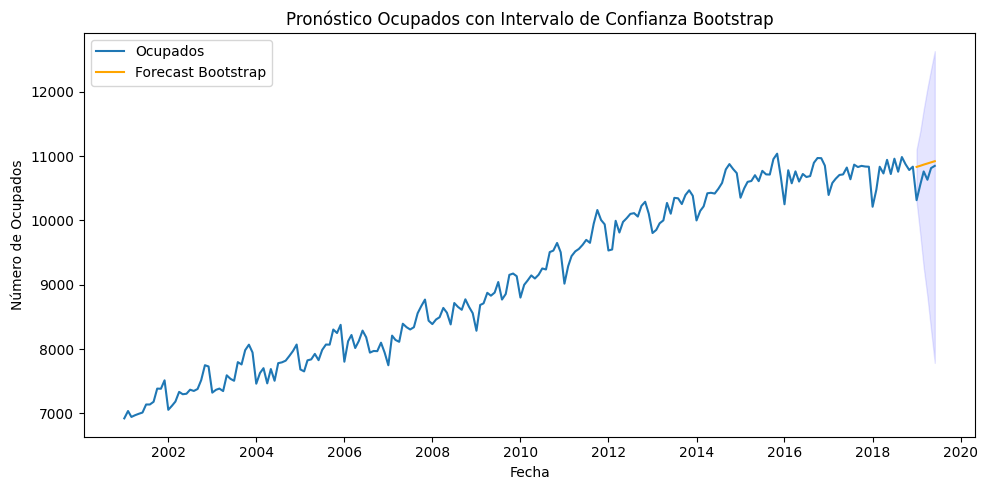

In [133]:
fig = plt.figure(figsize=(10, 5))

# Línea histórica
plt.plot(data["mes"],data["Ocupados"],label="Ocupados")

# Pronóstico puntual
plt.plot(preds.index, preds['Point_forecast'], label="Forecast Bootstrap", color='orange')

# Intervalo de confianza
plt.fill_between(preds.index, preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)

# Leyenda y formato
plt.legend()
plt.xlabel("Fecha")
plt.ylabel("Número de Ocupados")
plt.title("Pronóstico Ocupados con Intervalo de Confianza Bootstrap")
plt.tight_layout()
plt.show()


## **Ejercicio en Clase**

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses empleando los métodos vistos en la clase. Compare
los resultados con el mejor modelo encontrado en el ejercicio anterior.

Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

In [134]:
# 1. Asegúrate de que 'mes' es datetime y es el índice
data["mes"] = pd.to_datetime(data["mes"])
data.set_index("mes", inplace=True)

# 2. Dividir train/test
train_len = 216
train_Ocupados = data[["Ocupados"]][:train_len]
test_Ocupados = data[["Ocupados"]][train_len:]

In [135]:
h = len(test_Ocupados)  # Número de períodos a pronosticar (6)

# Bootstrap a partir de residuos del modelo
res = model.resid()  # residuos del entrenamiento

my_samples = []
for _ in range(1000):
    muestra = np.random.choice(res, size=h, replace=True)
    my_samples.append(muestra)

q1 = np.quantile(my_samples, 0.025, axis=0)
q2 = np.quantile(my_samples, 0.975, axis=0)

# Predicción puntual (6 pasos)
forecast = model.predict(n_periods=h)
forecast_index = test_Ocupados.index


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [136]:
model = auto_arima(train_Ocupados,
                   start_p=0, start_q=0,
                   max_p=10, max_q=10,
                   d=None,                  # Identifica automáticamente si hay diferenciación
                   seasonal=False,          # Cambiar a True si sabes que hay estacionalidad
                   information_criterion='aic',
                   stepwise=True,
                   suppress_warnings=True,
                   trace=True)

# Mostrar resumen del modelo
print(model.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2864.791, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2855.272, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2846.080, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2864.805, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2825.418, Time=0.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2826.765, Time=0.85 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2826.900, Time=2.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2828.288, Time=0.87 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2849.394, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2842.993, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 5.778 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  216
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1408.709
Date:                Thu, 19 Jun 2025   AIC                           2825.418
Time:                        22:42:50   BIC                           2838.901
Sample:                    01-01-2001   HQIC                          2830.866
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
interc

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [137]:
model = auto_arima(train_Ocupados,
                   start_p=0, start_q=0,
                   max_p=10, max_q=10,
                   d=None,                  # Identifica automáticamente si hay diferenciación
                   seasonal=False,          # Cambiar a True si sabes que hay estacionalidad
                   information_criterion='bic',
                   stepwise=True,
                   suppress_warnings=True,
                   trace=True)

# Mostrar resumen del modelo
print(model.summary())

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=2871.533, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=2865.384, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=2856.192, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=2868.176, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=2838.901, Time=0.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=2843.618, Time=0.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=2843.753, Time=0.43 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=2841.770, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : BIC=2862.877, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=2853.105, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.284 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  216
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1408.709
Date:                Thu, 19 Jun 2025   AIC                           2825.418
Time:                        22:42:52   BIC                           2838.901
Sample:                    01-01-2001   HQIC                          2830.866
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
interc

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


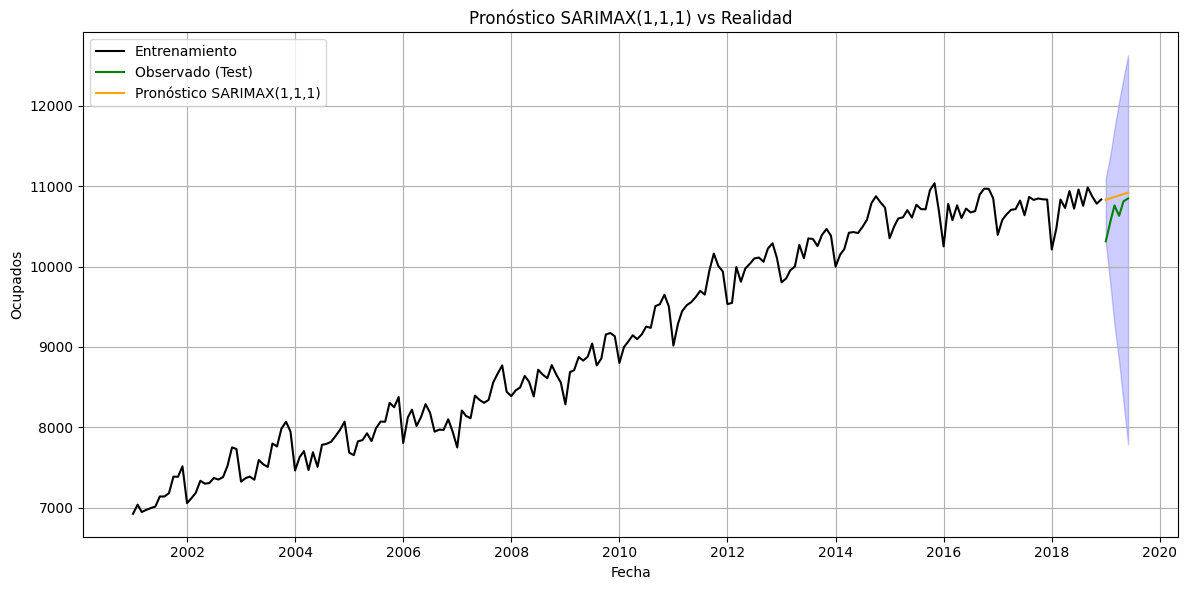

            Point_forecast      lower_95      upper_95
mes                                                   
2019-01-01    10831.577377  10295.542679  11101.502091
2019-02-01    10849.322672   9777.534104  11389.172100
2019-03-01    10867.067968   9270.049538  11722.066830
2019-04-01    10884.813263   8817.798261  12054.961559
2019-05-01    10902.558558   8304.474253  12343.393145
2019-06-01    10920.303854   7786.465678  12629.965017


In [138]:
plt.figure(figsize=(12, 6))

# Serie original
plt.plot(train_Ocupados.index, train_Ocupados["Ocupados"], label="Entrenamiento", color='black')
plt.plot(test_Ocupados.index, test_Ocupados["Ocupados"], label="Observado (Test)", color='green')

# Pronóstico
plt.plot(preds.index, preds["Point_forecast"], label="Pronóstico SARIMAX(1,1,1)", color='orange')
plt.fill_between(preds.index, preds["lower_95"], preds["upper_95"], color='blue', alpha=0.2)

plt.title("Pronóstico SARIMAX(1,1,1) vs Realidad")
plt.xlabel("Fecha")
plt.ylabel("Ocupados")
plt.legend()
plt.grid(True)
plt.tight_layout()

#impimir en jpg
plt.savefig("Pronóstico SARIMAX(1,1,1) vs Realidad.jpg", dpi=300, bbox_inches="tight")
plt.show()

print(preds.head(6))

In [139]:
# Asegurar que los índices coinciden: usar los mismos 6 meses en test_Ocupados
eval_real = test_Ocupados.loc[preds.index]  # Coincidir por fecha

# Cálculo de métricas
rmse_sa = np.sqrt(mean_squared_error(eval_real, preds['Point_forecast']))
print(f"RMSE SARIMAX(1,1,1): {rmse_sa}")


RMSE SARIMAX(1,1,1): 271.04653809629536


### **Pronóstico para los siguientes 6 mese modelo SARIMAX(1,1,1)**

In [140]:
model = SARIMAX(y,
                order=(1, 1, 1),
                seasonal_order=(0, 0, 0, 0),  # sin estacionalidad
                trend='c',                    # con intercepto
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()
print(results.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               Ocupados   No. Observations:                  222
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1438.830
Date:                Thu, 19 Jun 2025   AIC                           2885.660
Time:                        22:42:53   BIC                           2899.217
Sample:                    01-01-2001   HQIC                          2891.135
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.7671      2.471      3.953      0.000       4.924      14.610
ar.L1          0.4361      0.100      4.372      0.000       0.241       0.632
ma.L1         -0.8623      0.052    -16.617      0.0

In [141]:
# Número de meses a pronosticar
h = 6

# Realizar el pronóstico
forecast = results.get_forecast(steps=h)

# Valores pronosticados y bandas de confianza
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Fechas futuras (mensuales) desde la última observación
future_dates = pd.date_range(start=y.index[-1] + pd.DateOffset(months=1), periods=h, freq='MS')

# Crear DataFrame de predicciones
preds = pd.DataFrame({
    'Point_forecast': pred_mean.values,
    'lower_95': conf_int.iloc[:, 0].values,
    'upper_95': conf_int.iloc[:, 1].values
}, index=future_dates)

# Redondear valores para una presentación más limpia
tabla = preds.round(2).reset_index()
tabla.columns = ['Fecha', 'Pronóstico', 'Límite Inferior 95%', 'Límite Superior 95%']

# Mostrar tabla con líneas
print(tabulate(tabla, headers='keys', tablefmt='grid', showindex=False))


+---------------------+--------------+-----------------------+-----------------------+
| Fecha               |   Pronóstico |   Límite Inferior 95% |   Límite Superior 95% |
+=====================+==============+=======================+=======================+
| 2019-07-01 00:00:00 |      10865.2 |               10527.4 |               11202.9 |
+---------------------+--------------+-----------------------+-----------------------+
| 2019-08-01 00:00:00 |      10882.4 |               10493   |               11271.8 |
+---------------------+--------------+-----------------------+-----------------------+
| 2019-09-01 00:00:00 |      10899.7 |               10488.9 |               11310.6 |
+---------------------+--------------+-----------------------+-----------------------+
| 2019-10-01 00:00:00 |      10917   |               10493.3 |               11340.8 |
+---------------------+--------------+-----------------------+-----------------------+
| 2019-11-01 00:00:00 |      10934.4 |     

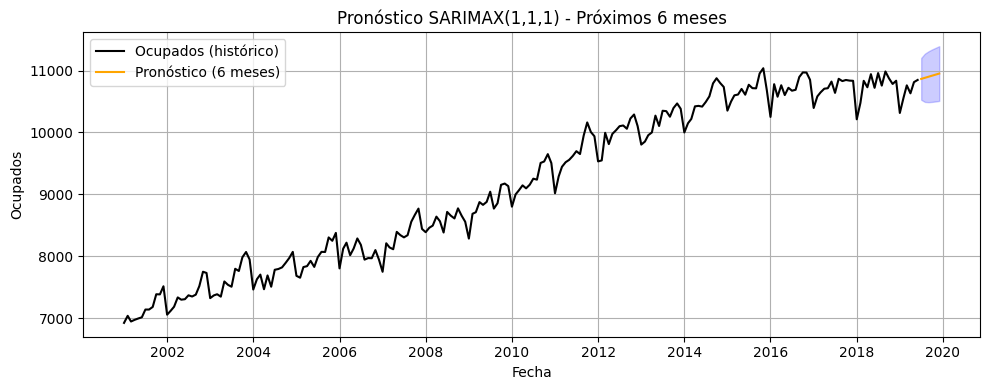

In [142]:
plt.figure(figsize=(10, 4))
plt.plot(y.index, y, label="Ocupados (histórico)", color='black')
plt.plot(preds.index, preds["Point_forecast"], label="Pronóstico (6 meses)", color='orange')
plt.fill_between(preds.index, preds["lower_95"], preds["upper_95"], color='blue', alpha=0.2)

plt.title("Pronóstico SARIMAX(1,1,1) - Próximos 6 meses")
plt.xlabel("Fecha")
plt.ylabel("Ocupados")
plt.legend()
plt.grid(True)
plt.tight_layout()

#descargar en un jpg
plt.savefig("Pronóstico SARIMAX(1,1,1) - Próximos 6 meses.jpg", dpi=300, bbox_inches="tight")

plt.show()


In [143]:
residuos = results.resid
print(residuos)

mes
2001-01-01    6923.604000
2001-02-01   -1405.484889
2001-03-01    -183.317188
2001-04-01     -34.328074
2001-05-01     -22.763772
                 ...     
2019-02-01     -36.488223
2019-03-01      55.436228
2019-04-01    -179.190845
2019-05-01      72.847476
2019-06-01       9.116312
Length: 222, dtype: float64


### **Autocorrelación**

In [144]:
signo = data['Ocupados']>0

In [145]:
# Aplica sobre los residuos del modelo, no sobre Ocupados
signo_resid = results.resid > 0
z, p = runstest_1samp(signo_resid, correction=False)

print(f"Z: {z}, p-valor: {p}")


Z: -1.8900283942699003, p-valor: 0.05875416267112231


No se rechaza H₀ al 0,058 no hay evidencia de que haya una autocorrelación fuerte en los residuos.

In [146]:
Resul_lb_bp = sm.stats.acorr_ljungbox(data['Ocupados'], lags=range(1,21), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,215.466151,8.818153e-49,212.580444,3.757527e-48,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
2,425.045838,5.040446e-93,418.417636,1.386005e-91,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
3,629.973395,3.201138e-136,618.770917,8.590288e-134,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
4,830.534686,1.866623e-178,813.960031,7.268819e-175,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,1028.006530,5.191558e-220,1005.260880,4.364213e-215,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,1222.035167,8.145806e-261,1192.359923,2.155332e-254,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,1412.841689,6.426069e-301,1375.500111,7.718370e-293,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,1599.512253,0.000000e+00,1553.837168,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
9,1782.749605,0.000000e+00,1728.076257,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
10,1963.258217,0.000000e+00,1898.914764,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


Con el resultado anterior rechazamos la hipótesis nula de que los residuos** no son autorelacionables.**

### **Homoscedasticidad y Heteroscedasticidad**

In [147]:
sm.stats.acorr_ljungbox((data['Ocupados']-data['Ocupados'].mean())**2, lags=range(1,21), return_df=True,boxpierce=True )

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,185.144285,3.650054e-42,182.664674,1.269512e-41
2,351.726827,4.202327e-77,346.272528,6.425041e-76
3,503.667333,7.654204e-109,494.821504,6.322880e-107
4,644.388355,3.822171e-138,631.773213,2.056334e-135
5,779.932738,2.537066e-166,763.081835,1.120126e-162
6,908.018395,6.939421e-193,886.593004,2.972305e-188
7,1033.010933,8.866253e-219,1006.563521,4.598527e-213
8,1150.214310,5.463849e-243,1118.534603,3.804834e-236
9,1265.945521,6.998913e-267,1228.582585,8.181347e-259
10,1382.954411,4.749866e-291,1339.323142,1.245900e-281


Se **rechaza la hipótesis nula** de homocedasticidad en todos los lags. Esto indica que los residuos presentan heterocedasticidad, es decir, varianza no constante en el tiempo.

### **Normalidad**

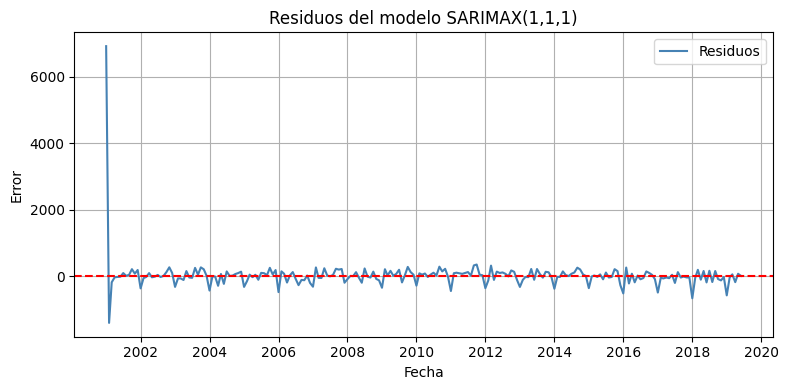

In [148]:
plt.figure(figsize=(8, 4))
plt.plot(residuos, color='steelblue', label="Residuos")
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuos del modelo SARIMAX(1,1,1)")
plt.xlabel("Fecha")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()

#descargar en un jpg
plt.savefig("Residuos del modelo SARIMAX(1,1,1).jpg", dpi=300, bbox_inches="tight")
plt.show()


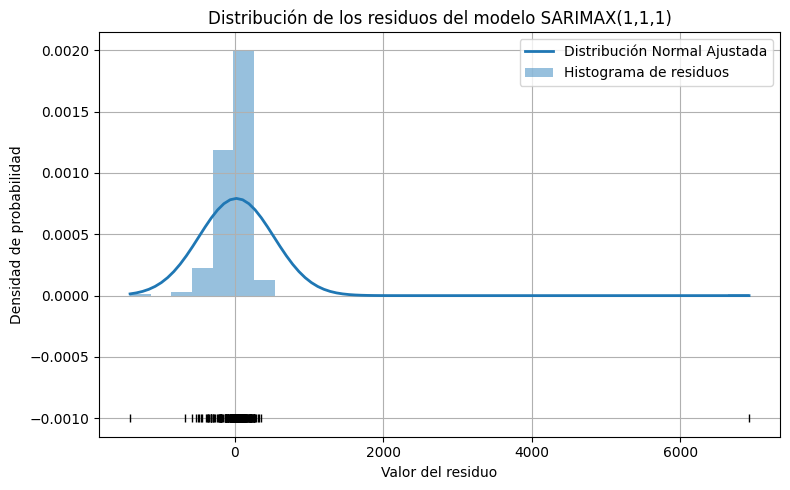

In [149]:
# Asumiendo que ya calculaste los residuos así:
residuos = results.resid

# Ajustar distribución normal a los residuos
mu, sigma = stats.norm.fit(residuos)

# Crear valores teóricos de la normal para graficar
x_hat = np.linspace(min(residuos), max(residuos), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(8, 5))

# Curva teórica
ax.plot(x_hat, y_hat, linewidth=2, label='Distribución Normal Ajustada')

# Histograma de los residuos
ax.hist(residuos, bins=30, density=True, color="#3182bd", alpha=0.5, label='Histograma de residuos')

# Marcas para cada punto
ax.plot(residuos, np.full_like(residuos, -0.001), '|k', markeredgewidth=1)

# Estética del gráfico
ax.set_title('Distribución de los residuos del modelo SARIMAX(1,1,1)')
ax.set_xlabel('Valor del residuo')
ax.set_ylabel('Densidad de probabilidad')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [150]:
stats.shapiro(data['Ocupados'])

ShapiroResult(statistic=0.9111439682568433, pvalue=3.039085379954234e-10)

In [151]:
stats.jarque_bera(data['Ocupados'])

SignificanceResult(statistic=20.11813814008792, pvalue=4.2795865091983345e-05)

Con un p-valor tan bajo (< 0.05), se rechaza la hipótesis nula de normalidad. Es decir, los residuos del modelo **no siguen una distribución normal**.

Podemos concluir que el modelo Sarimax (1,1,1) no podria ser empleado, ya que los residuales,no cumplen los supuestos necesarios para el buen uso del modelo.

Se debe realizar un boostraping para establecer los intervalor de confianza

### **Boostrap**

In [152]:
h = 6  # número de pasos a pronosticar
forecast_base = results.forecast(steps=h)


In [153]:
# Repeticiones de muestreo
n_simulaciones = 1000

# Guardar pronósticos simulados
bootstrap_forecasts = []

for _ in range(n_simulaciones):
    # Muestreo aleatorio de residuos
    errores_bootstrap = np.random.choice(res, size=h, replace=True)

    # Pronóstico con suma acumulada de errores
    simulacion = forecast_base + np.cumsum(errores_bootstrap)
    bootstrap_forecasts.append(simulacion)

# Convertir a matriz
bootstrap_forecasts = np.array(bootstrap_forecasts)

lower_bound = np.percentile(bootstrap_forecasts, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_forecasts, 97.5, axis=0)

# Crear fechas futuras
last_date = y.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=h, freq='MS')

# Crear DataFrame de resultados
preds = pd.DataFrame({
    'Point_forecast': forecast_base,
    'lower_95': lower_bound,
    'upper_95': upper_bound
}, index=future_dates)

# Redondear valores para una presentación más limpia
tabla = preds.round(2).reset_index()
tabla.columns = ['Fecha', 'Pronóstico', 'Límite Inferior 95%', 'Límite Superior 95%']

# Mostrar tabla con líneas
print(tabulate(tabla, headers='keys', tablefmt='grid', showindex=False))

# Guardar como imagen
plt.savefig("Resultados_tabla3.png", dpi=300, bbox_inches="tight")
plt.show()

+---------------------+--------------+-----------------------+-----------------------+
| Fecha               |   Pronóstico |   Límite Inferior 95% |   Límite Superior 95% |
+=====================+==============+=======================+=======================+
| 2019-07-01 00:00:00 |      10865.2 |               10396.6 |               11135.9 |
+---------------------+--------------+-----------------------+-----------------------+
| 2019-08-01 00:00:00 |      10882.4 |               10311.6 |               11318.2 |
+---------------------+--------------+-----------------------+-----------------------+
| 2019-09-01 00:00:00 |      10899.7 |               10221.2 |               11580   |
+---------------------+--------------+-----------------------+-----------------------+
| 2019-10-01 00:00:00 |      10917   |               10113.3 |               11732.8 |
+---------------------+--------------+-----------------------+-----------------------+
| 2019-11-01 00:00:00 |      10934.4 |     

<Figure size 640x480 with 0 Axes>

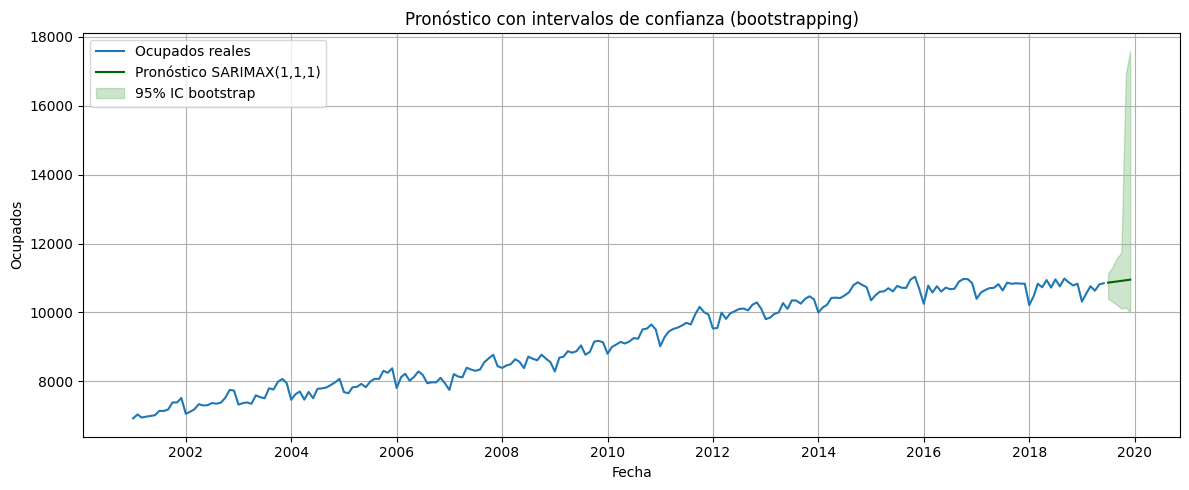

In [154]:
plt.figure(figsize=(12, 5))
plt.plot(y, label='Ocupados reales')
plt.plot(preds['Point_forecast'], label='Pronóstico SARIMAX(1,1,1)', color='darkgreen')
plt.fill_between(preds.index, preds['lower_95'], preds['upper_95'], color='green', alpha=0.2, label='95% IC bootstrap')
plt.title("Pronóstico con intervalos de confianza (bootstrapping)")
plt.xlabel("Fecha")
plt.ylabel("Ocupados")
plt.legend()
plt.grid(True)
plt.tight_layout()

#descarga jpg
plt.savefig("Pronóstico con intervalos de confianza (bootstrapping).jpg", dpi=300, bbox_inches="tight")
plt.show()



In [155]:
rmse_pronostico_sarimax = np.sqrt(mean_squared_error(eval_real, preds['Point_forecast']))
print(f"RMSE Pronósticos SARIMAX (1,1,1) 6 meses: {rmse_pronostico_sarimax}")

RMSE Pronósticos SARIMAX (1,1,1) 6 meses: 298.5018199869734


El modelo SARIMAX(1,1,1) logró capturar adecuadamente las tendencias suaves presentes en la serie temporal, manteniendo una línea de pronóstico relativamente estable a lo largo del horizonte de predicción. El error cuadrático medio (RMSE) obtenido fue de aproximadamente 298. Esto representa un error relativo cercano al 2.7 %, lo que sugiere un desempeño razonablemente preciso por parte del modelo. Adicionalmente, se utilizaron intervalos de confianza generados mediante bootstrapping, los cuales proporcionan una estimación más realista de la incertidumbre asociada al pronóstico, ya que consideran posibles efectos de heterocedasticidad y desviaciones de normalidad en los residuos.

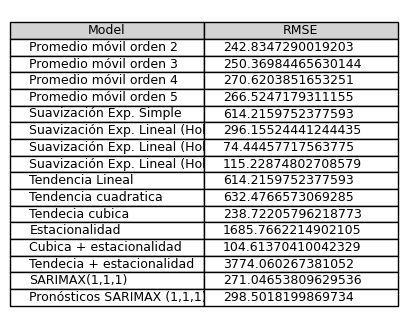

In [156]:
RMSE = pd.DataFrame({
    'Model': ["Promedio móvil orden 2","Promedio móvil orden 3","Promedio móvil orden 4","Promedio móvil orden 5","Suavización Exp. Simple","Suavización Exp. Lineal (Holt)", "Suavización Exp. Lineal (Holt-Winters) Aditivo",
"Suavización Exp. Lineal (Holt-Winters) Multiplicativo",'Tendencia Lineal', 'Tendencia cuadratica','Tendecia cubica',  'Estacionalidad', 'Cubica + estacionalidad','Tendecia + estacionalidad', 'SARIMAX(1,1,1)','Pronósticos SARIMAX (1,1,1) 6 meses'],
    'RMSE': [rmse_ma_2, rmse_ma_3, rmse_ma_4, rmse_ma_5, rmse, rmse_holt, rmse_hw_add, rmse_hw_mul,rmse_lineal, rmse_quad, rmse_cubic, rmse_season, rmse_cu_es,rmse_season_pol2,rmse_sa, rmse_pronostico_sarimax]
})
df = pd.DataFrame(RMSE)

fig, ax = plt.subplots(figsize=(5, 4))
ax.axis("tight")
ax.axis("off")

tabla = ax.table(cellText=df.values, colLabels=df.columns, cellLoc="left", loc="center",
                 colColours=["lightgray"] * df.shape[1])
tabla.auto_set_font_size(False)
tabla.set_fontsize(9)

# Guardar como imagen
plt.savefig("Resultados_FINALES.png", dpi=300, bbox_inches="tight")
plt.show()